## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]) - ca.if_else(t>98, p[3]*y[0], 0),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2] + ca.if_else(t>84, p[3]*y[0], 0),
        p[2]*y[1]
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 1
clip = None
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

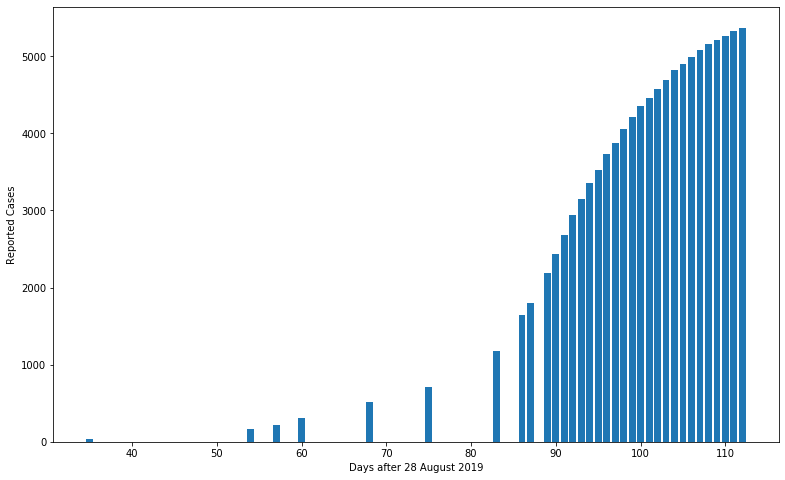

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

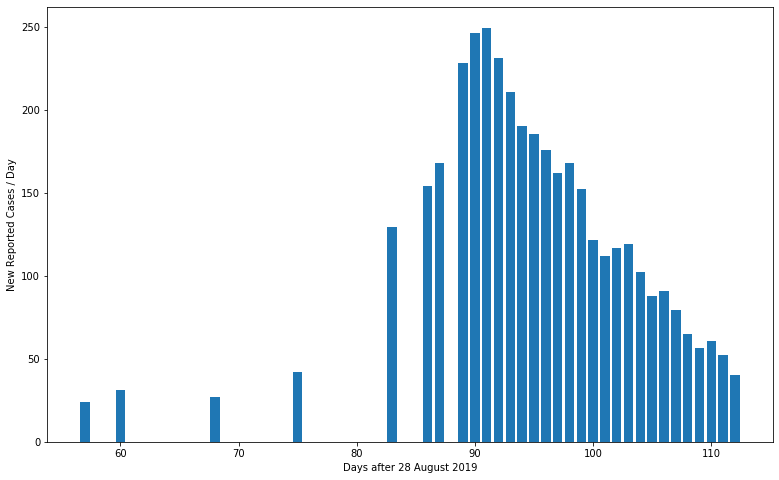

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8, 0]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 4
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1900

Total number of variables............................:      124
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

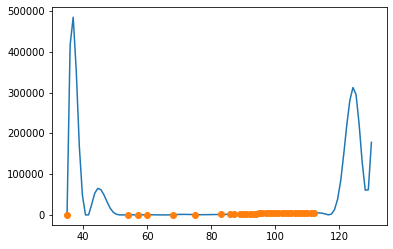

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = ubg[0]

In [14]:
prange = np.logspace(-6, 5, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1900

Total number of variables............................:      124
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  60  1.0608092e+02 0.00e+00 4.22e-03  -8.6 1.42e+03 -12.0 5.10e-01 1.00e+00f  1
  70  1.0607951e+02 0.00e+00 7.42e-04  -8.6 3.24e+03    -  9.50e-01 3.27e-01f  1
  80  1.0607950e+02 0.00e+00 1.55e-04  -8.6 2.12e+04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:   1.0607949607303864e+02    1.0607949607303864e+02
Dual infeasibility......:   9.4344435350348951e-13    9.4344435350348951e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035857897920e-09    2.5059035857897920e-09
Overall NLP error.......:   2.5059035857897920e-09    2.5059035857897920e-09


Number of objective function evaluations             = 111
Number of objective gradient evaluations             = 89
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 111
Number of equality constraint Jacob

  40  1.0618295e+02 0.00e+00 1.07e-01  -8.6 9.91e+04 -14.1 5.04e-01 9.18e-03f  1
  50  1.0617787e+02 0.00e+00 1.04e-02  -8.6 3.21e+03 -13.4 2.38e-01 2.78e-01f  1
  60  1.0617756e+02 0.00e+00 7.99e-06  -8.6 9.70e+00 -13.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:   1.0617755718726626e+02    1.0617755718726626e+02
Dual infeasibility......:   3.0427178950857007e-10    3.0427178950857007e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0914318826297424e-10    9.0914318826297424e-10
Overall NLP error.......:   9.0914318826297424e-10    9.0914318826297424e-10


Number of objective function evaluations             = 77
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 77
Number of equality constraint Jacobia


Number of Iterations....: 94

                                   (scaled)                 (unscaled)
Objective...............:   1.0626137465379765e+02    1.0626137465379765e+02
Dual infeasibility......:   4.4988262378634583e-10    4.4988262378634583e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059724673811729e-09    2.5059724673811729e-09
Overall NLP error.......:   2.5059724673811729e-09    2.5059724673811729e-09


Number of objective function evaluations             = 115
Number of objective gradient evaluations             = 95
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 115
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 95
Number of Lagrangian Hessian evaluations             = 94
Total CPU secs in IPOPT (w/o function evaluations)   =      0.166
Total CPU secs in NLP function evaluati

Overall NLP error.......:   2.5059035614466425e-09    2.5059035614466425e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 85
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 69
Number of Lagrangian Hessian evaluations             = 68
Total CPU secs in IPOPT (w/o function evaluations)   =      0.121
Total CPU secs in NLP function evaluations           =      0.037

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.44ms ( 28.73us)   2.46ms ( 28.97us)        85
       nlp_g  |   1.20ms ( 14.11us)   1.18ms ( 13.94us)        85
    nlp_grad  |  66.00us ( 66.00us)  66.02us ( 66.02us)         1
  nlp_grad_f  |   4.06ms ( 58.00us)   4.08ms ( 58.28us)        70
  nlp_hess_l  |  26.52ms

  60  1.0637538e+02 0.00e+00 2.41e-01  -8.6 3.03e+03 -11.6 1.00e+00 1.00e+00f  1
  70  1.0635270e+02 0.00e+00 8.65e-02  -8.6 1.30e+02  -8.2 4.02e-02 2.59e-01f  1
  80  1.0635081e+02 0.00e+00 7.23e-02  -8.6 2.76e+03  -9.4 1.06e-02 6.56e-04f  1
  90  1.0634629e+02 0.00e+00 9.97e-02  -8.6 7.22e+02 -10.5 8.31e-02 4.77e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0634326e+02 0.00e+00 5.41e-03  -8.6 3.64e+04    -  1.47e-01 1.60e-01h  3
 110  1.0634326e+02 0.00e+00 4.42e-08  -8.6 1.97e+01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:   1.0634325938849588e+02    1.0634325938849588e+02
Dual infeasibility......:   8.5384963194666241e-14    8.5384963194666241e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.....

  20  1.0667384e+02 0.00e+00 9.76e+00  -2.5 1.35e+04    -  1.00e+00 5.00e-01f  2
  30  1.0650246e+02 0.00e+00 1.74e-03  -3.8 1.19e+02    -  1.00e+00 1.00e+00h  1
  40  1.0649829e+02 0.00e+00 4.80e-03  -8.6 2.80e+01  -8.3 1.00e+00 1.00e+00f  1
  50  1.0649306e+02 0.00e+00 3.63e+00  -8.6 2.42e+04 -13.1 1.00e+00 7.34e-01f  1
  60  1.0639992e+02 0.00e+00 2.88e-01  -8.6 7.64e+03 -11.5 8.31e-01 5.49e-02f  1
  70  1.0636317e+02 0.00e+00 1.33e-01  -8.6 2.01e+04 -12.7 5.07e-02 3.04e-02f  1
  80  1.0636228e+02 0.00e+00 7.63e-05  -8.6 2.81e+02 -14.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:   1.0636228088887026e+02    1.0636228088887026e+02
Dual infeasibility......:   3.1007273405746978e-09    3.1007273405746978e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059326384024645e-09    2.5059326384024645e-09
Overall NLP error......

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0649485e+02 0.00e+00 2.04e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.1047205e+02 0.00e+00 1.61e+01  -1.0 1.74e+03    -  7.01e-01 1.00e+00f  1
  20  1.0702749e+02 0.00e+00 6.43e-01  -3.8 1.30e+02  -6.9 1.00e+00 1.00e+00f  1
  30  1.0640111e+02 0.00e+00 9.43e-01  -3.8 9.73e+02  -9.7 1.00e+00 3.15e-01f  2
  40  1.0638734e+02 0.00e+00 1.58e-03  -5.7 6.46e+03    -  1.00e+00 1.00e+00h  1
  50  1.0638731e+02 0.00e+00 2.08e-12  -8.6 2.56e-01    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   1.0638731033307661e+02    1.0638731033307661e+02
Dual infeasibility......:   2.0800089733558464e-12    2.08000

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1900

Total number of variables............................:      124
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0653633e+02 0.00e+00 2.21e+01  -1.0 0.00e+00    -  0.00e+00 0.

  10  1.1902070e+02 0.00e+00 3.83e+02  -1.0 8.25e+03    -  6.27e-01 5.00e-01f  2
  20  1.0665389e+02 0.00e+00 5.30e+00  -3.8 3.42e+04    -  5.43e-01 1.00e+00f  1
  30  1.0648787e+02 0.00e+00 2.48e-01  -5.7 9.48e+01    -  9.70e-01 1.00e+00f  1
  40  1.0648734e+02 0.00e+00 7.41e-07  -8.6 6.81e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   1.0648733624211816e+02    1.0648733624211816e+02
Dual infeasibility......:   9.4287113917237290e-11    9.4287113917237290e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.8417295687650942e-10    9.8417295687650942e-10
Overall NLP error.......:   9.8417295687650942e-10    9.8417295687650942e-10


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 0
Number of ineq

  20  1.0771616e+02 0.00e+00 3.78e-01  -3.8 4.21e+01  -6.4 1.00e+00 1.00e+00f  1
  30  1.0663952e+02 0.00e+00 2.12e+00  -3.8 1.82e+02  -8.9 1.00e+00 1.00e+00f  1
  40  1.0662935e+02 0.00e+00 5.74e-07  -5.7 4.64e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:   1.0662932403042804e+02    1.0662932403042804e+02
Dual infeasibility......:   2.4275790665232033e-10    2.4275790665232033e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6410222177615744e-09    2.6410222177615744e-09
Overall NLP error.......:   2.6410222177615744e-09    2.6410222177615744e-09


Number of objective function evaluations             = 59
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 59
Number of equality constraint Jacobia

  20  1.2454708e+02 0.00e+00 6.06e+01  -1.0 2.81e+02  -6.9 1.00e+00 1.00e+00f  1
  30  1.3526776e+02 0.00e+00 1.01e+02  -1.0 2.44e+02  -7.1 1.00e+00 1.00e+00f  1
  40  1.3916237e+02 0.00e+00 8.77e+01  -1.0 4.10e+02  -7.7 1.00e+00 1.00e+00f  1
  50  1.4127285e+02 0.00e+00 1.58e+03  -1.0 6.35e+04    -  2.60e-01 2.74e-02f  4
  60  1.4182761e+02 0.00e+00 1.53e+03  -1.0 2.01e+06    -  1.56e-02 1.41e-03f  4
  70  1.4254741e+02 0.00e+00 3.12e+03  -1.0 3.57e+04    -  9.98e-01 1.25e-01f  4
  80  1.4205715e+02 0.00e+00 8.52e+02  -1.0 3.54e+03  -9.7 1.00e+00 1.00e+00f  1
  90  1.4287891e+02 0.00e+00 2.24e+00  -1.0 1.19e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4008384e+02 0.00e+00 9.33e+02  -2.5 2.24e+03  -9.9 1.00e+00 1.00e+00f  1
 110  1.3907008e+02 0.00e+00 1.84e+03  -2.5 4.68e+03 -10.2 1.00e+00 5.00e-01f  2
 120  1.3798380e+02 0.00e+00 1.89e+03  -2.5 1.93e+04 -10.5 1.00e+00 1.25e-01f  4
 130  1.3724788e+02 0.00e+00

  30  1.0967860e+02 0.00e+00 4.72e+00  -1.7 4.78e+03    -  1.00e+00 1.00e+00f  1
  40  1.0733410e+02 0.00e+00 3.12e+00  -3.8 1.28e+02  -8.9 1.00e+00 1.00e+00f  1
  50  1.0730899e+02 0.00e+00 6.22e-06  -5.7 1.67e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   1.0730895272917864e+02    1.0730895272917864e+02
Dual infeasibility......:   5.2518298793125206e-09    5.2518298793125206e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.6142916147637540e-09    4.6142916147637540e-09
Overall NLP error.......:   5.2518298793125206e-09    5.2518298793125206e-09


Number of objective function evaluations             = 81
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 81
Number of equality constraint Jacobia

  40  1.3795890e+02 0.00e+00 1.54e+03  -1.0 1.24e+04    -  1.00e+00 5.00e-01f  2
  50  1.3834583e+02 0.00e+00 4.75e+01  -1.0 1.33e+03    -  1.00e+00 1.00e+00f  1
  60  1.3050054e+02 0.00e+00 5.98e-01  -2.5 2.18e+02  -8.7 1.00e+00 1.00e+00f  1
  70  1.2863436e+02 0.00e+00 1.19e+03  -2.5 1.64e+04 -10.8 1.00e+00 5.00e-01f  2
  80  1.1598358e+02 0.00e+00 5.94e+01  -2.5 2.59e+02  -6.5 9.12e-01 1.00e+00f  1
  90  1.0851537e+02 0.00e+00 9.94e+00  -2.5 1.51e+04    -  6.48e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0838105e+02 0.00e+00 1.65e-04  -3.8 1.95e-01  -8.2 1.00e+00 1.00e+00f  1
 110  1.0837943e+02 0.00e+00 6.09e-02  -8.6 1.47e+04    -  1.00e+00 8.84e-01h  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:   1.0837943026398723e+02    1.0837943026398723e+02
Dual infeasibility......:   1.5559500312428580e-10    1.5559500312428580e-10
Constraint vio

  20  1.2188463e+02 0.00e+00 1.25e-03  -1.0 3.03e+01    -  1.00e+00 1.00e+00f  1
  30  1.1069247e+02 0.00e+00 1.78e+00  -2.5 8.32e+01  -9.7 1.00e+00 1.00e+00f  1
  40  1.1062784e+02 0.00e+00 2.93e-01  -5.7 2.12e+04    -  1.00e+00 1.00e+00f  1
  50  1.1062775e+02 0.00e+00 2.30e-08  -8.6 1.12e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   1.1062775033772606e+02    1.1062775033772606e+02
Dual infeasibility......:   5.8424604197305620e-11    5.8424604197305620e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2791402294667974e-10    9.2791402294667974e-10
Overall NLP error.......:   9.2791402294667974e-10    9.2791402294667974e-10


Number of objective function evaluations             = 68
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of ineq

  30  1.1524931e+02 0.00e+00 5.52e-05  -8.6 1.59e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   1.1524931152981372e+02    1.1524931152981372e+02
Dual infeasibility......:   2.6668979590819532e-09    2.6668979590819532e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.9253973560992794e-09    2.9253973560992794e-09
Overall NLP error.......:   2.9253973560992794e-09    2.9253973560992794e-09


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 36
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 33
Number of Lagrangian Hessian evaluations             = 32
Total CPU secs in IPOPT (w

  20  1.2448684e+02 0.00e+00 2.33e-01  -5.7 9.89e+02    -  9.98e-01 8.38e-01f  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   1.2448669481078001e+02    1.2448669481078001e+02
Dual infeasibility......:   4.6494919582719828e-09    4.6494919582719828e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5551329370879143e-09    2.5551329370879143e-09
Overall NLP error.......:   4.6494919582719828e-09    4.6494919582719828e-09


Number of objective function evaluations             = 31
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 31
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 26
Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in IPOPT (w

  10  1.5184618e+02 0.00e+00 6.81e-02  -2.5 2.23e+00  -5.0 1.00e+00 1.00e+00f  1
  20  1.5180094e+02 0.00e+00 1.41e-04  -5.7 1.17e-01  -6.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   1.5180093544406208e+02    1.5180093544406208e+02
Dual infeasibility......:   3.1595650641618592e-09    3.1595650641618592e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601233781e-09    2.5059035601233781e-09
Overall NLP error.......:   3.1595650641618592e-09    3.1595650641618592e-09


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 26
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 28
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 26
Num

  30  2.1758071e+02 0.00e+00 2.92e-05  -5.7 1.41e+01  -9.7 1.00e+00 1.00e+00h  1
  40  2.1755011e+02 0.00e+00 5.87e+00  -5.7 1.42e+03 -10.9 1.00e+00 1.00e+00f  1
  50  2.1751934e+02 0.00e+00 2.41e+01  -5.7 8.93e+02 -10.2 1.00e+00 1.00e+00f  1
  60  2.1747414e+02 0.00e+00 3.49e+01  -5.7 3.86e+01  -7.8 1.00e+00 1.00e+00f  1
  70  2.1736585e+02 0.00e+00 6.94e+01  -5.7 5.89e+01  -8.0 1.00e+00 5.39e-02f  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   2.1736179904334003e+02    2.1736179904334003e+02
Dual infeasibility......:   2.7772227811028642e-11    2.7772227811028642e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5088654290578801e-09    2.5088654290578801e-09
Overall NLP error.......:   2.5088654290578801e-09    2.5088654290578801e-09


Number of objective function evaluations             = 108
Number of objective gradient evaluations       

  60  3.2158858e+02 0.00e+00 8.59e+00  -5.7 9.25e+01  -8.3 1.00e+00 1.00e+00f  1
  70  3.2138245e+02 0.00e+00 1.68e-04  -5.7 1.73e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   3.2138244842490406e+02    3.2138244842490406e+02
Dual infeasibility......:   6.3300602153392013e-09    6.3300602153392013e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5479044708722600e-09    2.5479044708722600e-09
Overall NLP error.......:   6.3300602153392013e-09    6.3300602153392013e-09


Number of objective function evaluations             = 147
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 147
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 74
N

  70  5.1597113e+02 0.00e+00 2.07e+02  -5.7 5.16e+03  -7.9 3.35e-02 2.76e-02f  5
  80  5.1548647e+02 0.00e+00 1.13e+01  -5.7 5.44e+01  -7.3 1.00e+00 5.40e-01f  1

Number of Iterations....: 86

                                   (scaled)                 (unscaled)
Objective...............:   5.1548636246914180e+02    5.1548636246914180e+02
Dual infeasibility......:   1.0024646134002172e-10    1.0024646134002172e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062818522576984e-09    2.5062818522576984e-09
Overall NLP error.......:   2.5062818522576984e-09    2.5062818522576984e-09


Number of objective function evaluations             = 155
Number of objective gradient evaluations             = 87
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 155
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 87
N

  20  8.5553125e+02 0.00e+00 4.90e+00  -1.0 1.08e+00  -3.7 1.00e+00 1.00e+00f  1
  30  8.5554408e+02 0.00e+00 2.71e+02  -1.7 3.38e+04    -  1.00e+00 1.25e-01f  4
  40  8.5531553e+02 0.00e+00 2.25e+02  -2.5 6.92e+00  -5.7 1.00e+00 1.00e+00f  1
  50  8.5519922e+02 0.00e+00 2.94e+01  -3.8 4.71e+03 -10.5 1.00e+00 1.00e+00f  1
  60  8.5502201e+02 0.00e+00 2.58e+02  -3.8 8.59e+01  -8.1 1.00e+00 1.00e+00f  1
  70  8.5455213e+02 0.00e+00 8.57e+01  -3.8 2.14e+02  -8.3 1.00e+00 1.00e+00f  1
  80  8.5420835e+02 0.00e+00 8.92e+01  -3.8 5.76e+01  -7.7 1.00e+00 1.00e+00f  1
  90  8.5372144e+02 0.00e+00 4.85e+00  -3.8 1.73e+02  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.5229036e+02 0.00e+00 7.94e+01  -3.8 9.45e+01    -  1.00e+00 1.56e-02f  7

Number of Iterations....: 108

                                   (scaled)                 (unscaled)
Objective...............:   8.5228839100079597e+02    8.5228839100079597e+02
Dual infea

  60  1.3155209e+03 0.00e+00 5.74e+03  -1.7 1.47e+01  -4.0 1.00e+00 1.00e+00f  1
  70  1.2906967e+03 0.00e+00 8.28e+03  -1.7 4.63e+04    -  1.64e-01 3.35e-02f  5
  80  1.2447349e+03 0.00e+00 1.81e+03  -1.7 4.36e+01  -5.3 1.00e+00 1.00e+00f  1
  90  1.2379567e+03 0.00e+00 7.72e+02  -1.7 4.38e+04    -  6.93e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2373895e+03 0.00e+00 9.41e-06  -1.7 7.93e-01    -  1.00e+00 1.00e+00h  1
 110  1.2371862e+03 0.00e+00 1.17e-05  -3.8 1.62e+00    -  1.00e+00 1.00e+00h  1
 120  1.2371772e+03 0.00e+00 1.86e-08  -8.6 5.17e-11    -  1.00e+00 1.00e+00h  1
 130  1.2371772e+03 0.00e+00 2.52e-08  -9.0 3.77e-11    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 130

                                   (scaled)                 (unscaled)
Objective...............:   1.2371771856489174e+03    1.2371771856489174e+03
Dual infeasibility......:   2.5236658984795213e-08    2.5236658984795213e-08
Constraint vio

  50  1.7540510e+03 0.00e+00 4.47e-01  -5.7 2.33e+04    -  1.00e+00 1.00e+00f  1
  60  1.7540373e+03 0.00e+00 1.42e-09  -8.6 7.37e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:   1.0402342179054033e+01    1.7540373070487342e+03
Dual infeasibility......:   1.4181580354488688e-09    2.3912904023452009e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8667299256352227e-09    4.8338644819069885e-07
Overall NLP error.......:   2.8667299256352227e-09    4.8338644819069885e-07


Number of objective function evaluations             = 95
Number of objective gradient evaluations             = 61
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 95
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 61
Num

 260  2.4571889e+03 0.00e+00 1.15e+02  -3.8 1.05e+02  -8.3 1.00e+00 2.50e-01f  3
 270  2.3993670e+03 0.00e+00 1.50e+02  -3.8 6.31e+01  -6.8 1.00e+00 1.00e+00f  1
 280  2.3454139e+03 0.00e+00 1.61e+02  -3.8 1.19e+02  -7.9 1.00e+00 5.00e-01f  2
 290  2.2736537e+03 0.00e+00 1.03e+02  -3.8 8.41e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.2145171e+03 0.00e+00 7.50e+01  -3.8 5.47e+02  -8.0 1.00e+00 1.25e-01f  4
 310  2.1655741e+03 0.00e+00 2.78e-01  -3.8 9.47e-01  -5.5 1.00e+00 1.00e+00f  1
 320  2.1516150e+03 0.00e+00 3.85e-01  -3.8 9.29e+00  -7.8 1.00e+00 1.00e+00f  1
 330  2.1514430e+03 0.00e+00 1.62e+00  -5.7 1.33e+04    -  1.00e+00 1.00e+00H  1
 340  2.1514313e+03 0.00e+00 1.62e+00  -8.6 5.76e+04    -  1.00e+00 5.35e-02h  1

Number of Iterations....: 347

                                   (scaled)                 (unscaled)
Objective...............:   9.6342617633868048e+00    2.1514297265062596e+03
Dual infea

  30  2.9775905e+03 0.00e+00 7.81e-01  -3.8 2.57e+00    -  1.00e+00 1.00e+00f  1
  40  2.9775884e+03 0.00e+00 3.34e-09  -8.6 2.66e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   1.2389120893546828e+03    2.9775884489270288e+03
Dual infeasibility......:   3.3429924323549742e-09    8.0345132935263001e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065956635441514e-09    6.0243259857018973e-09
Overall NLP error.......:   3.3429924323549742e-09    8.0345132935263001e-09


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 51
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Num

  80  3.5123344e+03 0.00e+00 5.09e+02  -5.7 2.46e+02  -7.3 1.00e+00 1.56e-02f  7
  90  3.5122402e+03 0.00e+00 8.32e+02  -5.7 2.11e+03 -10.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5121650e+03 0.00e+00 1.92e-03  -5.7 7.74e+00  -7.8 1.00e+00 1.00e+00f  1
 110  3.5120120e+03 0.00e+00 1.00e+01  -5.7 1.54e+02  -8.9 1.00e+00 1.00e+00f  1
 120  3.5119363e+03 0.00e+00 4.02e+00  -5.7 3.18e+02  -9.2 1.00e+00 1.00e+00f  1
 130  3.5118260e+03 0.00e+00 4.91e-01  -5.7 8.66e+01  -8.6 1.00e+00 1.00e+00f  1
 140  3.5116724e+03 0.00e+00 4.84e-02  -5.7 2.47e+01  -7.9 1.00e+00 1.00e+00f  1
 150  3.5114986e+03 0.00e+00 2.39e-01  -5.7 5.63e+01  -8.2 1.00e+00 1.00e+00f  1
 160  3.5111481e+03 0.00e+00 1.83e-01  -5.7 2.38e+00  -6.6 1.00e+00 1.00e+00f  1
 170  3.5109266e+03 0.00e+00 4.74e+00  -5.7 5.33e+00  -6.9 1.00e+00 1.00e+00f  1
 180  3.5105584e+03 0.00e+00 3.66e-01  -5.7 2.21e-01  -5.3 1.00e+00 1.00e+00f  1
 190  3.5102189e+03 0.00e+00

  30  3.7570163e+03 0.00e+00 1.39e+04  -1.0 7.60e+02    -  8.38e-01 2.23e-02f  6
  40  3.7594172e+03 0.00e+00 1.66e+04  -1.0 1.23e+03    -  7.68e-01 5.00e-01f  2
  50  3.7587553e+03 0.00e+00 7.41e+03  -1.0 5.12e+03    -  8.54e-01 2.50e-01f  3
  60  3.7572129e+03 0.00e+00 6.00e+02  -2.5 2.54e+00  -5.4 1.00e+00 1.00e+00f  1
  70  3.7571567e+03 0.00e+00 9.71e+02  -2.5 2.13e+02  -9.3 1.00e+00 2.50e-01f  3
  80  3.7571316e+03 0.00e+00 2.44e+00  -2.5 4.52e+01  -9.5 1.00e+00 1.00e+00f  1
  90  3.7570976e+03 0.00e+00 5.21e+02  -2.5 7.30e+00  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7570597e+03 0.00e+00 2.37e+02  -2.5 3.29e+02  -9.1 1.00e+00 2.50e-01f  3
 110  3.7570224e+03 0.00e+00 1.00e+01  -2.5 1.11e+02  -9.4 1.00e+00 1.00e+00f  1
 120  3.7569792e+03 0.00e+00 5.81e+01  -2.5 2.63e+02  -9.6 1.00e+00 1.00e+00f  1
 130  3.7569330e+03 0.00e+00 1.11e+02  -2.5 1.99e+01  -8.1 1.00e+00 1.00e+00f  1
 140  3.7569058e+03 0.00e+00

 460  3.8495337e+03 0.00e+00 1.06e+02  -8.6 2.92e+01  -8.5 1.00e+00 1.00e+00f  1
 470  3.8495237e+03 0.00e+00 3.84e-02  -8.6 6.92e+00  -7.8 1.00e+00 1.00e+00f  1
 480  3.8495116e+03 0.00e+00 8.10e-02  -8.6 1.39e+01  -8.1 1.00e+00 1.00e+00f  1
 490  3.8494856e+03 0.00e+00 9.36e+01  -8.6 2.49e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8494644e+03 0.00e+00 5.53e+00  -8.6 3.64e-01  -5.9 1.00e+00 1.00e+00f  1
 510  3.8494472e+03 0.00e+00 7.75e+01  -8.6 1.80e+01  -7.9 1.00e+00 1.00e+00f  1
 520  3.8494391e+03 0.00e+00 6.16e-01  -8.6 3.16e+01  -8.2 1.00e+00 1.00e+00f  1
 530  3.8494138e+03 0.00e+00 9.95e+01  -8.6 8.44e+00  -7.6 1.00e+00 1.00e+00f  1
 540  3.8493902e+03 0.00e+00 3.50e+00  -8.6 1.36e+02  -8.7 1.00e+00 1.00e+00f  1
 550  3.8493651e+03 0.00e+00 1.31e+00  -8.6 3.50e+01  -8.1 1.00e+00 1.00e+00f  1
 560  3.8493279e+03 0.00e+00 5.65e+00  -8.6 7.50e+01  -8.3 1.00e+00 1.00e+00f  1
 570  3.8492856e+03 0.00e+00

  40  4.1295012e+03 0.00e+00 5.08e+02  -1.7 1.78e+01  -5.1 1.00e+00 1.00e+00f  1
  50  4.0631404e+03 0.00e+00 1.11e+03  -1.7 1.97e+04    -  1.00e+00 6.25e-02f  5
  60  4.0616344e+03 0.00e+00 7.40e+02  -1.7 2.06e+04    -  1.00e+00 6.25e-02f  5
  70  4.0632029e+03 0.00e+00 6.57e+00  -1.7 2.45e+00  -5.6 1.00e+00 1.00e+00f  1
  80  4.0330575e+03 0.00e+00 1.07e+02  -2.5 1.77e+04    -  1.00e+00 2.50e-01f  3
  90  4.0268135e+03 0.00e+00 9.04e+01  -2.5 8.75e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0220383e+03 0.00e+00 5.94e+01  -2.5 6.67e+02    -  1.00e+00 1.00e+00f  1
 110  4.0185569e+03 0.00e+00 2.65e+01  -2.5 1.09e+03    -  1.00e+00 1.25e-01f  4
 120  4.0163745e+03 0.00e+00 9.12e+01  -2.5 4.93e+02    -  1.00e+00 5.00e-01f  2
 130  4.0153496e+03 0.00e+00 3.25e+01  -2.5 1.22e+02    -  1.00e+00 2.50e-01f  3
 140  4.0148486e+03 0.00e+00 2.10e+01  -2.5 6.45e+00  -7.4 1.00e+00 5.00e-01f  2
 150  4.0123000e+03 0.00e+00

 420  6.1338738e+04 0.00e+00 1.12e+05  -5.7 5.95e+00  -2.3 1.00e+00 1.56e-11f 33
 430  4.0929777e+03 0.00e+00 3.21e+00  -5.7 9.91e-01  -5.3 1.00e+00 1.00e+00f  1
 440  4.0928901e+03 0.00e+00 1.13e+00  -5.7 6.24e-01  -8.2 1.00e+00 1.00e+00h  1
 450  4.0928754e+03 0.00e+00 4.80e-04  -8.6 7.48e-02 -10.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 456

                                   (scaled)                 (unscaled)
Objective...............:   2.2216866379313107e+01    4.0928754257417158e+03
Dual infeasibility......:   9.1970520088580088e-09    1.6943158190559924e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0937623382407042e-10    1.6752874040047967e-07
Overall NLP error.......:   9.1970520088580088e-09    1.6943158190559924e-06


Number of objective function evaluations             = 1348
Number of objective gradient evaluations             = 456
Number of equality constraint evaluations            = 0
Number of 

 120  4.8272434e+03 0.00e+00 5.62e+02  -1.0 9.22e+02    -  1.00e+00 3.12e-02f  6
 130  4.8372531e+03 0.00e+00 3.26e-01  -1.0 6.54e-01  -4.8 1.00e+00 1.00e+00f  1
 140  4.4550468e+03 0.00e+00 1.15e+02  -1.7 6.46e+00  -6.4 1.00e+00 1.00e+00f  1
 150  4.4363990e+03 0.00e+00 1.76e+02  -1.7 1.00e+04    -  1.00e+00 1.56e-02f  7
 160  4.4204320e+03 0.00e+00 7.31e+02  -1.7 1.94e+01  -6.6 1.00e+00 1.00e+00f  1
 170  4.4067861e+03 0.00e+00 1.07e+02  -1.7 1.15e+02    -  1.00e+00 1.00e+00f  1
 180  4.3948350e+03 0.00e+00 1.68e+02  -1.7 9.32e+00  -6.9 1.00e+00 1.00e+00f  1
 190  4.3848080e+03 0.00e+00 3.28e+01  -1.7 1.74e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.3773526e+03 0.00e+00 5.67e+01  -1.7 5.13e+00  -7.1 1.00e+00 1.00e+00f  1
 210  4.3733130e+03 0.00e+00 3.68e+01  -1.7 4.09e+00    -  1.00e+00 1.00e+00h  1
 220  4.3384225e+03 0.00e+00 1.87e+01  -2.5 3.17e+00  -5.9 1.00e+00 1.00e+00f  1
 230  4.3275414e+03 0.00e+00

 250  4.4322715e+03 0.00e+00 2.08e+02  -2.5 4.23e+02    -  1.00e+00 5.00e-01f  2
 260  4.4259367e+03 0.00e+00 4.29e+01  -2.5 3.69e+00  -6.3 1.00e+00 1.00e+00f  1
 270  4.4225218e+03 0.00e+00 2.76e+02  -2.5 7.81e+01  -6.5 1.00e+00 3.12e-02f  6
 280  4.4200669e+03 0.00e+00 3.75e+02  -2.5 6.44e+02    -  1.00e+00 3.12e-02f  6
 290  4.4181996e+03 0.00e+00 2.95e+00  -2.5 1.12e+00  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.4164429e+03 0.00e+00 8.26e-01  -2.5 5.15e-01  -5.5 1.00e+00 1.00e+00f  1
 310  4.4151137e+03 0.00e+00 5.63e+00  -2.5 1.30e+00  -6.1 1.00e+00 1.00e+00f  1
 320  4.4137938e+03 0.00e+00 1.11e+00  -2.5 5.72e-01  -5.8 1.00e+00 1.00e+00f  1
 330  4.4128076e+03 0.00e+00 2.43e-01  -2.5 2.49e-01  -5.5 1.00e+00 1.00e+00f  1
 340  4.4119139e+03 0.00e+00 8.76e-01  -2.5 6.16e-01  -6.0 1.00e+00 1.00e+00f  1
 350  4.4110091e+03 0.00e+00 8.56e+01  -2.5 1.47e+02    -  1.00e+00 1.00e+00f  1
 360  4.4104199e+03 0.00e+00

 380  4.5556708e+03 0.00e+00 1.62e+02  -3.8 1.14e+01  -6.9 1.00e+00 5.00e-01f  2
 390  4.5546947e+03 0.00e+00 1.39e+02  -3.8 5.65e+03    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.5538719e+03 0.00e+00 3.51e+00  -3.8 9.37e-01  -5.8 1.00e+00 1.00e+00f  1
 410  4.5531091e+03 0.00e+00 8.19e-01  -3.8 4.32e-01  -5.5 1.00e+00 1.00e+00f  1
 420  4.5524380e+03 0.00e+00 1.88e-01  -3.8 1.94e-01  -5.2 1.00e+00 1.00e+00f  1
 430  4.5518039e+03 0.00e+00 6.01e+01  -3.8 6.23e+03    -  1.00e+00 1.56e-02f  7
 440  4.5513331e+03 0.00e+00 2.72e+01  -3.8 9.62e+00  -7.3 1.00e+00 2.50e-01f  3
 450  4.5509154e+03 0.00e+00 2.78e+00  -3.8 9.35e-01  -6.1 1.00e+00 1.00e+00f  1
 460  4.5505281e+03 0.00e+00 6.70e+01  -3.8 2.87e+03    -  1.00e+00 3.12e-02f  6
 470  4.5501842e+03 0.00e+00 8.01e+01  -3.8 3.74e+02    -  1.00e+00 1.25e-01f  4
 480  4.5498976e+03 0.00e+00 2.03e-01  -3.8 2.33e-01  -5.6 1.00e+00 1.00e+00f  1
 490  4.5496787e+03 0.00e+00

 480  4.7245638e+03 0.00e+00 5.37e-02  -3.8 1.11e-01  -5.6 1.00e+00 1.00e+00f  1
 490  4.7244495e+03 0.00e+00 6.01e-01  -3.8 3.37e-01  -6.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.7243591e+03 0.00e+00 2.92e+01  -3.8 1.92e+03    -  1.00e+00 2.50e-01f  3
 510  4.7242655e+03 0.00e+00 1.18e+01  -3.8 1.87e+00  -7.9 1.00e+00 1.00e+00f  1
 520  4.7241980e+03 0.00e+00 8.49e+00  -3.8 1.49e+00  -7.6 1.00e+00 1.00e+00h  1
 530  4.7241485e+03 0.00e+00 1.84e+00  -3.8 5.97e-01  -7.3 1.00e+00 1.00e+00h  1
 540  4.7249715e+03 0.00e+00 5.06e+02  -3.8 1.44e+02    -  1.00e+00 1.00e+00h  1
 550  4.7240048e+03 0.00e+00 1.35e+01  -5.7 1.57e+00  -7.6 1.00e+00 1.00e+00h  1
 560  4.7239811e+03 0.00e+00 1.42e+01  -5.7 1.62e+00  -8.7 1.00e+00 1.00e+00h  1
 570  4.7239579e+03 0.00e+00 6.15e+00  -5.7 2.81e+04    -  1.00e+00 1.25e-01f  4
 580  4.7239371e+03 0.00e+00 2.44e-02  -5.7 8.70e-02  -6.3 1.00e+00 1.00e+00f  1
 590  4.7239116e+03 0.00e+00

 580  4.9393094e+03 0.00e+00 5.20e+01  -3.8 2.27e+03    -  1.00e+00 1.56e-02f  7
 590  4.9390801e+03 0.00e+00 9.65e+01  -3.8 3.79e+03    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.9388700e+03 0.00e+00 7.55e+01  -3.8 1.21e+03    -  1.00e+00 3.12e-02f  6
 610  4.9386643e+03 0.00e+00 3.68e+01  -3.8 2.64e+00  -9.0 1.00e+00 1.00e+00f  1
 620  4.9384668e+03 0.00e+00 5.20e+01  -3.8 3.16e+03    -  1.00e+00 1.25e-01f  4
 630  4.9382811e+03 0.00e+00 6.30e+00  -3.8 1.25e+00  -8.4 1.00e+00 1.00e+00f  1
 640  4.9381536e+03 0.00e+00 2.05e+01  -3.8 4.99e+00  -7.7 1.00e+00 5.00e-01f  2
 650  4.9380219e+03 0.00e+00 1.42e+01  -3.8 9.43e-01  -6.6 1.00e+00 1.00e+00f  1
 660  4.9378986e+03 0.00e+00 1.69e+00  -3.8 7.83e-01  -6.7 1.00e+00 1.00e+00f  1
 670  4.9377955e+03 0.00e+00 4.72e+01  -3.8 6.31e+02    -  1.00e+00 6.25e-02f  5
 680  4.9376897e+03 0.00e+00 3.81e+01  -3.8 2.55e+02    -  1.00e+00 1.00e+00f  1
 690  4.9376096e+03 0.00e+00

 350  5.2078208e+03 0.00e+00 8.43e-02  -2.5 1.10e-01  -5.3 1.00e+00 1.00e+00f  1
 360  5.2072135e+03 0.00e+00 6.06e-01  -2.5 3.28e-01  -5.9 1.00e+00 1.00e+00f  1
 370  5.2065529e+03 0.00e+00 1.20e-01  -2.5 1.50e-01  -5.6 1.00e+00 1.00e+00f  1
 380  5.2060436e+03 0.00e+00 1.05e+00  -2.5 4.77e-01  -6.2 1.00e+00 1.00e+00h  1
 390  5.2055805e+03 0.00e+00 8.06e+00  -2.5 1.33e+00  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.2051511e+03 0.00e+00 1.53e+00  -2.5 5.73e-01  -6.4 1.00e+00 1.00e+00h  1
 410  5.2047747e+03 0.00e+00 6.30e+00  -2.5 1.24e+00  -7.0 1.00e+00 1.00e+00h  1
 420  5.2045575e+03 0.00e+00 6.92e+01  -2.5 1.38e+03    -  1.00e+00 5.00e-01f  2
 430  5.2041523e+03 0.00e+00 9.76e+00  -2.5 5.93e+01    -  1.00e+00 1.00e+00f  1
 440  5.2038307e+03 0.00e+00 6.76e+01  -2.5 1.31e+02    -  1.00e+00 1.00e+00h  1
 450  5.2035415e+03 0.00e+00 5.55e+01  -2.5 5.76e+01    -  1.00e+00 1.25e-01h  4
 460  1.1055187e+04 0.00e+00

1310  5.1958069e+03 0.00e+00 3.43e+01  -5.7 7.15e+03    -  1.00e+00 5.00e-01h  2
1320  5.1957542e+03 0.00e+00 9.56e-01  -5.7 3.62e-01  -6.8 1.00e+00 1.00e+00h  1
1330  5.1957163e+03 0.00e+00 6.92e+00  -5.7 9.61e-01  -7.4 1.00e+00 1.00e+00h  1
1340  5.1956821e+03 0.00e+00 5.78e+00  -5.7 4.96e+04    -  4.88e-01 1.56e-02f  7
1350  5.1956348e+03 0.00e+00 5.58e+00  -5.7 6.40e-01  -6.9 1.00e+00 1.00e+00f  1
1360  5.1956104e+03 0.00e+00 4.33e+01  -5.7 1.05e+04    -  1.00e+00 2.50e-01h  3
1370  5.1955606e+03 0.00e+00 1.74e+01  -5.7 1.69e+04    -  1.00e+00 3.12e-02f  6
1380  5.1955091e+03 0.00e+00 1.20e+01  -5.7 1.35e+00  -7.5 1.00e+00 1.00e+00h  1
1390  5.1954587e+03 0.00e+00 1.05e+01  -5.7 1.11e+00  -6.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.1954053e+03 0.00e+00 3.03e+01  -5.7 3.41e+00  -8.0 1.00e+00 5.00e-01h  2
1410  5.1953542e+03 0.00e+00 1.81e+01  -5.7 5.52e+03    -  1.00e+00 1.00e+00f  1
1420  5.1952966e+03 0.00e+00

 300  5.5556837e+03 0.00e+00 3.12e+02  -2.5 1.10e+01  -6.0 1.00e+00 2.50e-01f  3
 310  5.5403859e+03 0.00e+00 1.70e+02  -2.5 2.56e+00  -6.3 1.00e+00 1.00e+00f  1
 320  5.5294711e+03 0.00e+00 2.31e+02  -2.5 5.38e+00  -6.5 1.00e+00 5.00e-01f  2
 330  5.5212790e+03 0.00e+00 4.41e+02  -2.5 4.21e+00  -6.8 1.00e+00 1.00e+00f  1
 340  5.5152767e+03 0.00e+00 1.37e+02  -2.5 3.75e+00  -7.0 1.00e+00 5.00e-01f  2
 350  5.5112112e+03 0.00e+00 4.40e+01  -2.5 2.81e+00  -7.3 1.00e+00 1.00e+00f  1
 360  5.5089756e+03 0.00e+00 9.76e+01  -2.5 1.29e+02    -  1.00e+00 1.00e+00f  1
 370  5.5078699e+03 0.00e+00 1.31e+01  -2.5 4.85e+01    -  1.00e+00 5.00e-01f  2
 380  5.5074845e+03 0.00e+00 6.80e+02  -3.8 2.31e+02    -  8.37e-01 6.25e-02f  5
 390  5.5046203e+03 0.00e+00 5.36e+02  -3.8 1.07e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.5039545e+03 0.00e+00 2.70e+01  -3.8 4.45e+02    -  1.00e+00 5.00e-01f  2
 410  5.5037371e+03 0.00e+00

 390  5.8620348e+03 0.00e+00 1.19e+00  -2.5 6.42e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.8598176e+03 0.00e+00 9.02e+01  -3.8 1.56e+00  -7.9 1.00e+00 1.00e+00f  1
 410  5.8592778e+03 0.00e+00 5.27e+01  -3.8 2.25e+00  -9.9 1.00e+00 1.00e+00f  1
 420  5.8591529e+03 0.00e+00 1.02e+02  -3.8 8.76e+02    -  1.00e+00 1.25e-01f  4
 430  5.8591329e+03 0.00e+00 1.12e-07  -3.8 2.64e-04  -4.3 1.00e+00 1.00e+00h  1
 440  5.8590556e+03 0.00e+00 1.39e+01  -5.7 3.99e+04    -  1.00e+00 3.12e-02f  6
 450  5.8589686e+03 0.00e+00 7.60e+00  -5.7 1.14e+04    -  1.00e+00 5.00e-01h  2
 460  5.8589213e+03 0.00e+00 5.34e-08  -8.6 4.05e-03    -  1.00e+00 1.00e+00h  1
 470  5.8589213e+03 0.00e+00 8.07e-08  -9.0 1.28e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 474

                                   (scaled)                 (unscaled)
Objective...............:   1.8482577446391947e+01    5.8589212985368040e+03
Dual infea

  10  7.0370235e+03 0.00e+00 2.34e+02  -1.0 1.20e+01  -4.5 1.00e+00 1.00e+00f  1
  20  6.9732501e+03 0.00e+00 3.34e+03  -1.0 2.92e+00  -3.8 1.00e+00 1.00e+00f  1
  30  6.9986777e+03 0.00e+00 8.69e+02  -1.0 2.39e+00  -5.3 1.00e+00 1.00e+00f  1
  40  7.0239342e+03 0.00e+00 1.51e+03  -1.0 5.66e+00  -5.5 1.00e+00 1.00e+00f  1
  50  7.0561003e+03 0.00e+00 2.44e+03  -1.0 6.49e+00  -5.3 1.00e+00 1.00e+00f  1
  60  7.0536083e+03 0.00e+00 1.25e+03  -1.0 7.64e+00  -6.0 1.00e+00 1.00e+00f  1
  70  7.0864809e+03 0.00e+00 3.35e+03  -1.0 7.84e+00  -6.2 1.00e+00 5.00e-01f  2
  80  7.1508387e+03 0.00e+00 5.78e+03  -1.0 2.43e+04    -  1.00e+00 1.25e-01f  4
  90  7.1584362e+03 0.00e+00 7.91e+00  -1.0 2.02e-01  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.1661358e+03 0.00e+00 1.83e+03  -1.0 1.17e+01  -5.9 1.00e+00 2.50e-01f  3
 110  7.2006766e+03 0.00e+00 4.30e+03  -1.0 2.44e+04    -  1.00e+00 3.12e-02f  6
 120  7.2201460e+03 0.00e+00

 170  7.5626338e+03 0.00e+00 2.49e+02  -1.0 3.48e+01    -  1.00e+00 2.50e-01f  3
 180  7.4680252e+03 0.00e+00 5.81e+03  -1.7 6.41e+00  -6.5 1.00e+00 1.00e+00f  1
 190  7.4367003e+03 0.00e+00 5.51e+02  -1.7 1.18e+00  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.4123905e+03 0.00e+00 9.86e+02  -1.7 1.48e+00  -6.1 1.00e+00 1.00e+00f  1
 210  7.3916582e+03 0.00e+00 4.06e+02  -1.7 1.99e+00  -6.4 1.00e+00 1.00e+00f  1
 220  7.3739508e+03 0.00e+00 2.65e+03  -1.7 5.92e+00  -7.0 1.00e+00 1.00e+00f  1
 230  7.3601574e+03 0.00e+00 2.96e+03  -1.7 6.04e+00  -6.8 1.00e+00 1.00e+00f  1
 240  7.3481950e+03 0.00e+00 3.28e+03  -1.7 4.59e+00  -6.6 1.00e+00 5.00e-01f  2
 250  7.3385151e+03 0.00e+00 1.01e+03  -1.7 6.85e+00  -6.9 1.00e+00 2.50e-01f  3
 260  7.3324926e+03 0.00e+00 1.19e+03  -1.7 5.73e+02    -  1.00e+00 1.00e+00f  1
 270  7.3270265e+03 0.00e+00 2.19e+02  -1.7 6.76e+00  -8.4 1.00e+00 1.00e+00f  1
 280  7.3216636e+03 0.00e+00

 310  7.9650284e+03 0.00e+00 5.95e+01  -1.7 1.31e+00    -  1.00e+00 1.00e+00f  1
 320  7.9551781e+03 0.00e+00 3.34e+02  -2.5 5.68e-01  -3.9 1.00e+00 1.00e+00f  1
 330  7.9496195e+03 0.00e+00 5.23e+02  -2.5 1.05e+01  -8.1 1.00e+00 1.00e+00f  1
 340  7.9455637e+03 0.00e+00 9.93e+02  -2.5 6.69e+02  -9.3 1.00e+00 2.24e-02f  5
 350  7.9424370e+03 0.00e+00 3.29e+03  -2.5 6.14e+03    -  1.00e+00 1.25e-01f  4
 360  7.9400775e+03 0.00e+00 3.49e+02  -2.5 1.41e+03    -  1.00e+00 2.50e-01f  3
 370  7.9387120e+03 0.00e+00 5.59e+02  -2.5 1.19e+03    -  1.00e+00 5.00e-01f  2
 380  7.9379463e+03 0.00e+00 2.96e+02  -2.5 4.97e+02    -  1.00e+00 1.00e+00f  1
 390  7.9375969e+03 0.00e+00 4.15e+02  -3.8 5.80e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  7.9366099e+03 0.00e+00 5.42e+01  -3.8 3.66e+03    -  1.00e+00 2.26e-01f  2
 410  7.9365776e+03 0.00e+00 8.14e+02  -3.8 9.24e-01  -7.5 1.00e+00 1.00e+00H  1
 420  7.9365301e+03 0.00e+00

 470  8.7076560e+03 0.00e+00 4.64e+02  -3.8 1.42e+01  -8.1 1.00e+00 1.00e+00f  1
 480  8.7009475e+03 0.00e+00 8.81e+02  -3.8 1.38e+02 -11.0 1.00e+00 1.00e+00f  1
 490  8.6956160e+03 0.00e+00 9.33e+02  -3.8 1.51e+02 -11.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.6917999e+03 0.00e+00 5.12e+02  -3.8 3.89e+01 -11.1 1.00e+00 5.00e-01f  2
 510  8.6893259e+03 0.00e+00 3.32e+02  -3.8 2.14e+01 -11.3 1.00e+00 5.00e-01f  2
 520  8.6878314e+03 0.00e+00 1.54e+02  -3.8 4.48e+01 -11.1 1.00e+00 1.00e+00f  1
 530  8.6872067e+03 0.00e+00 7.52e+01  -3.8 8.99e+00    -  1.00e+00 1.00e+00f  1
 540  8.6870069e+03 0.00e+00 2.09e+01  -3.8 1.24e+02 -12.3 1.00e+00 1.00e+00h  1
 550  8.6868477e+03 0.00e+00 1.72e+01  -5.7 4.93e+00 -10.5 1.00e+00 1.00e+00f  1
 560  8.6864712e+03 0.00e+00 4.09e-07  -5.7 1.78e-05  -4.6 1.00e+00 1.00e+00h  1
 570  8.6864113e+03 0.00e+00 6.14e-07  -8.6 1.17e-07    -  1.00e+00 1.00e+00H  1
 580  8.6864113e+03 0.00e+00

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

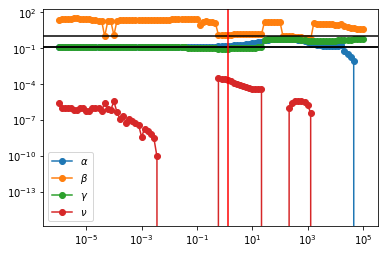

In [16]:
idx = 55
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\nu$')

for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

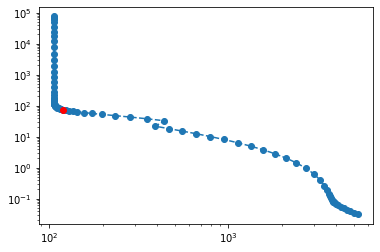

In [17]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

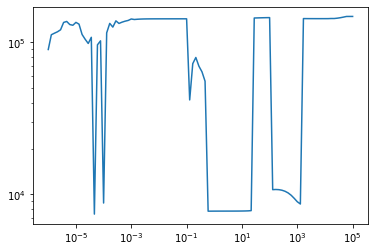

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

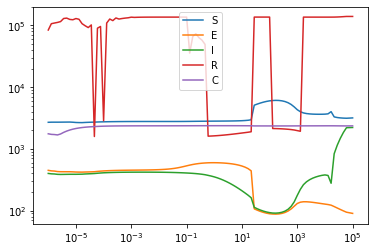

In [19]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [20]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


(0, 20000)

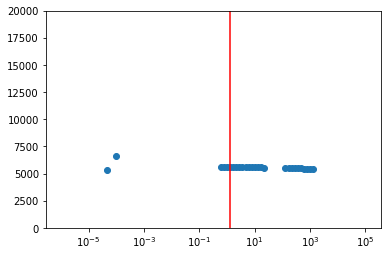

In [21]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [22]:
rinf(sols[idx])

5597.692145577813

/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


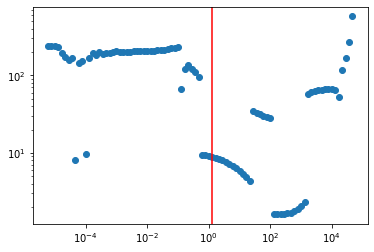

In [23]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [24]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3406.58), DM(1237.99), DM(349.136), DM(294.196), DM(1179.61)]

In [25]:
getx(sols[idx]['x'])[0][0]

DM(5598.46)

In [26]:
getp(sols[idx]['x'])

(DM(0.157353), DM(1.39945), DM(0.0963548), DM(0.000205543))

In [27]:
r0(sols[idx])

8.893688658516856

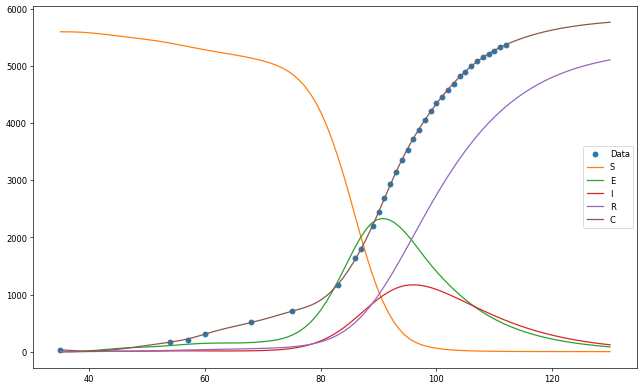

In [28]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

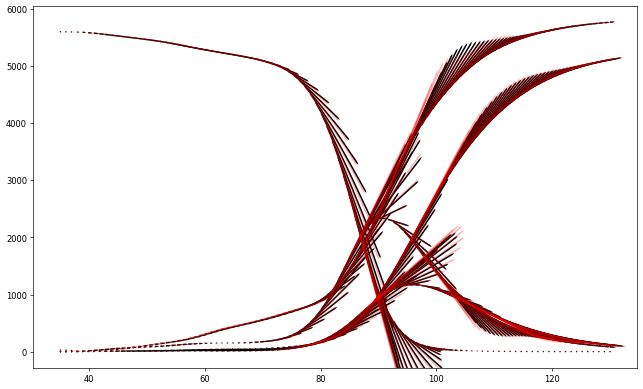

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

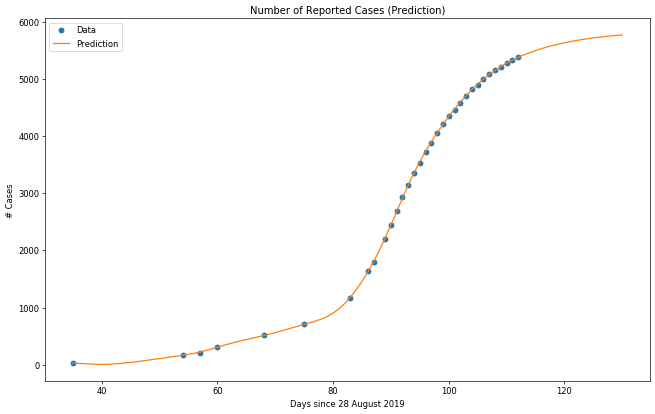

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

(0, 10000)

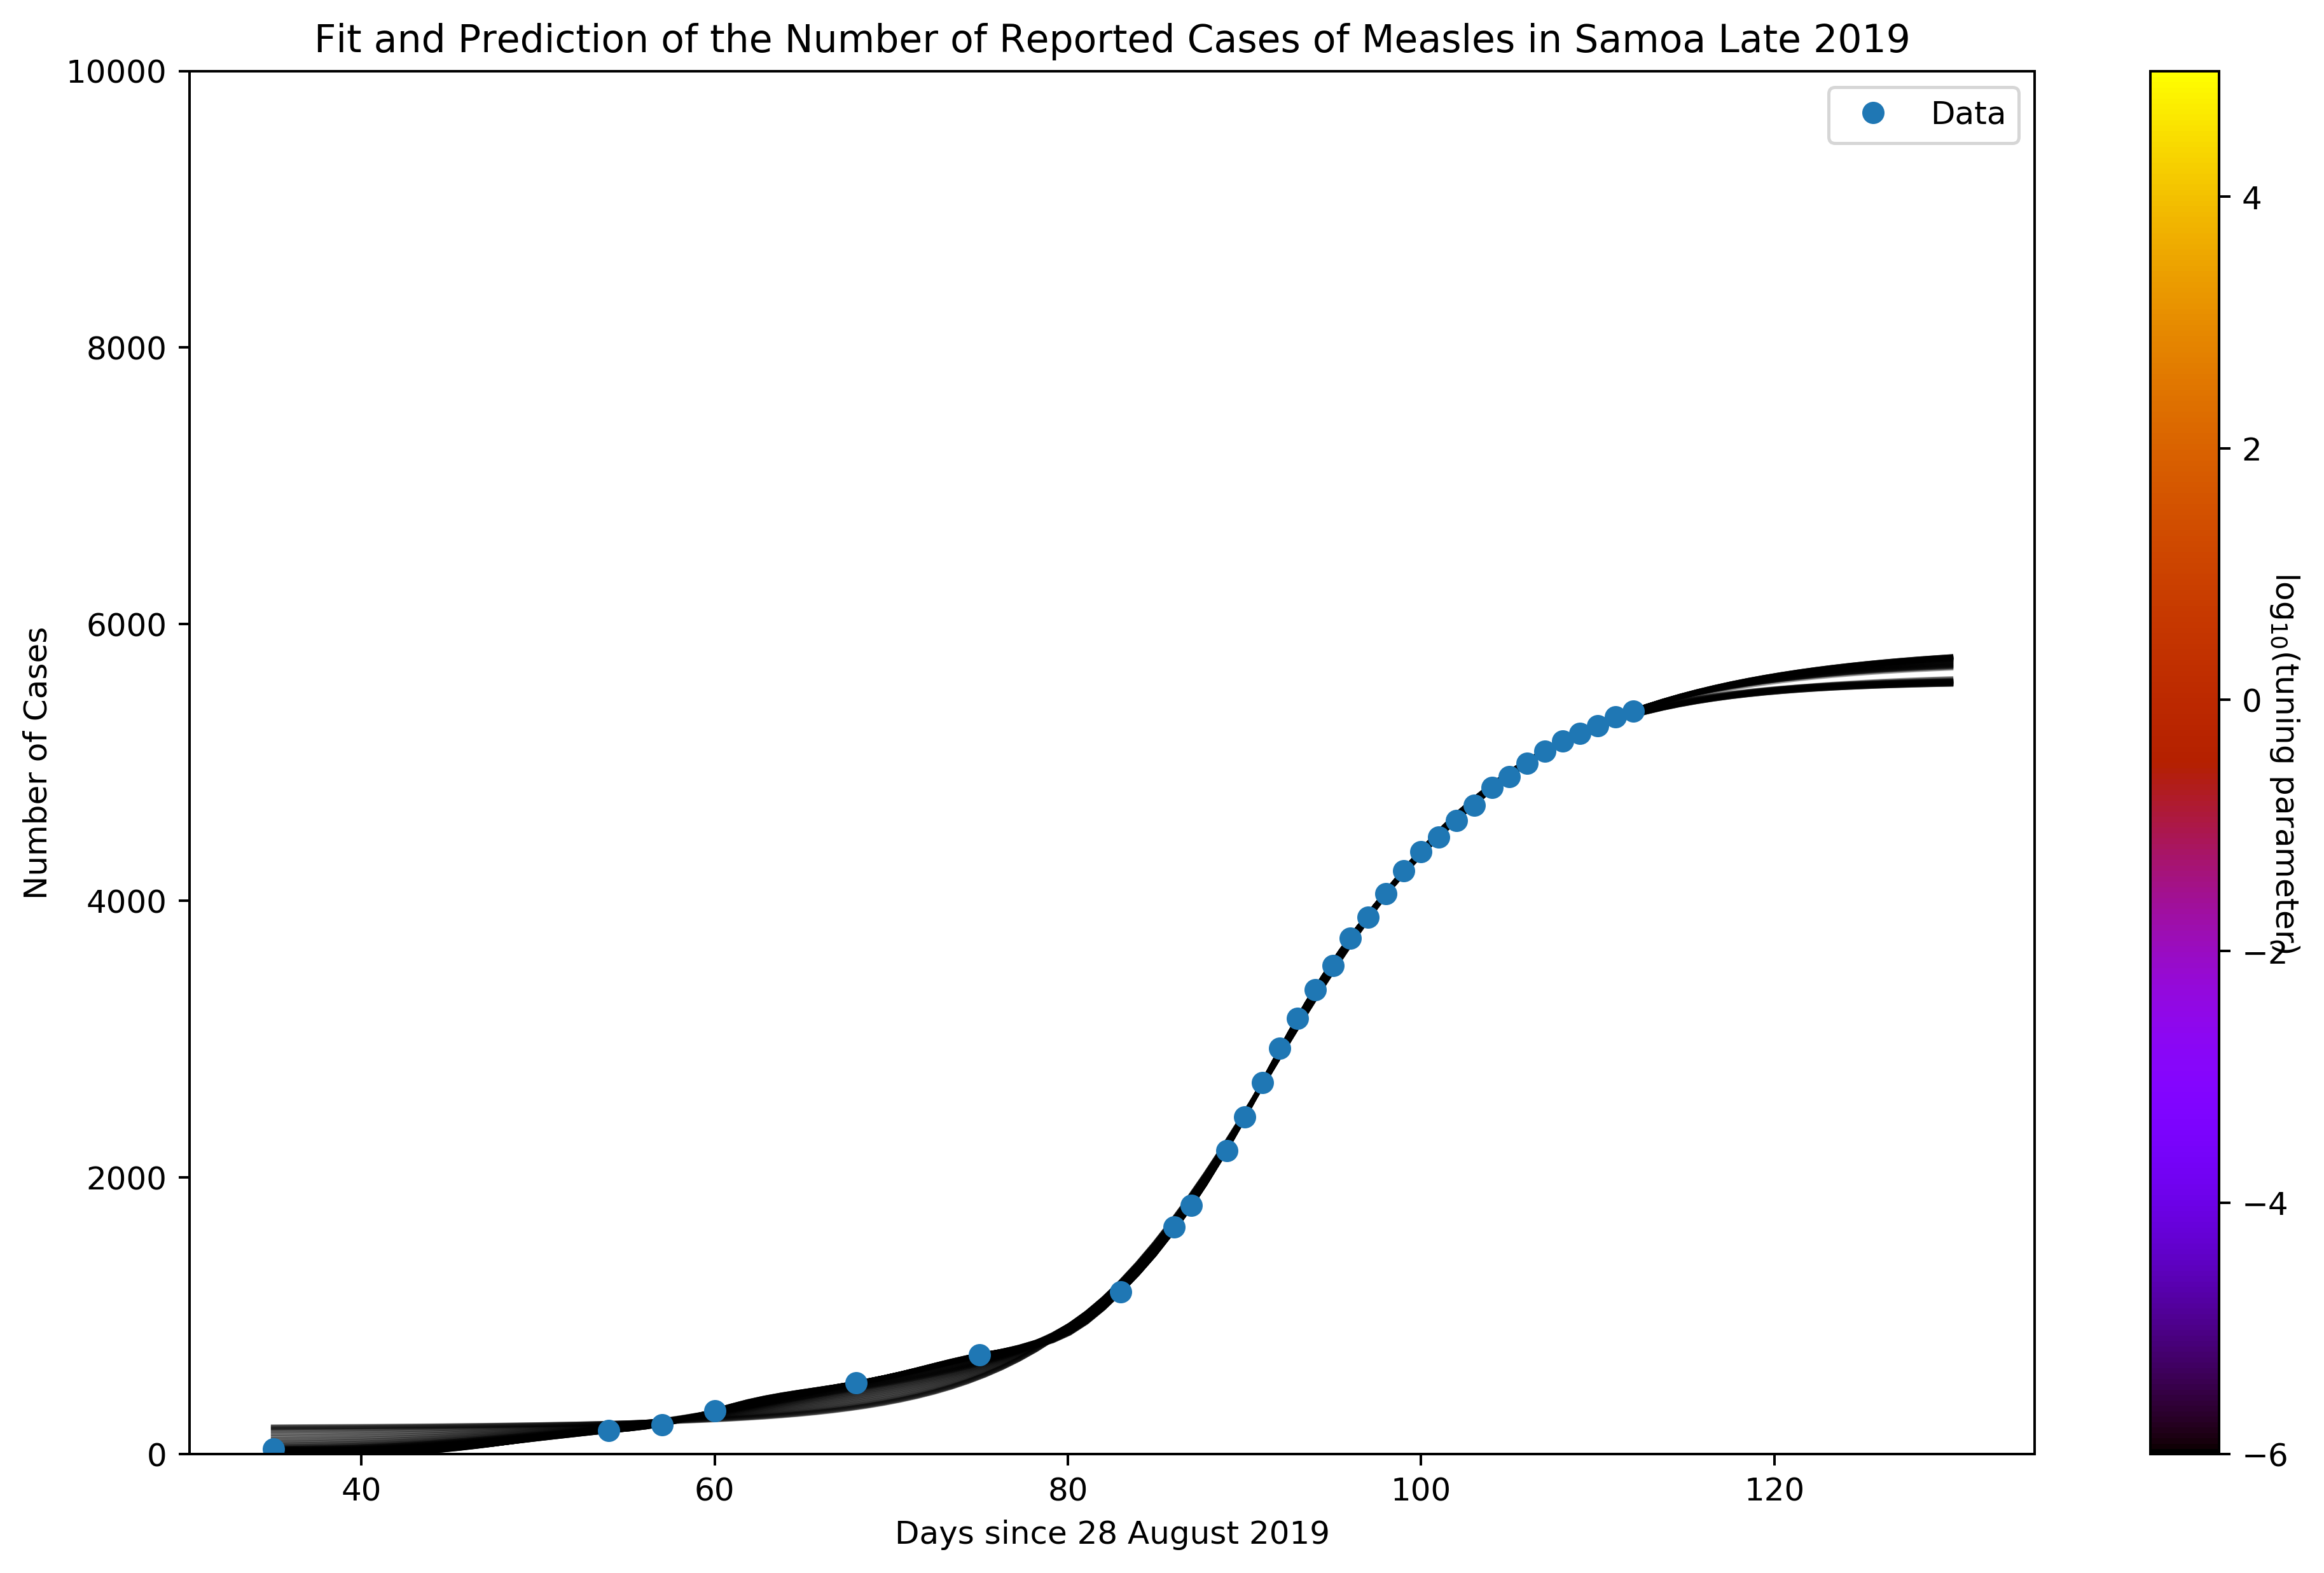

In [31]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('gnuplot')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[40:-15:]):
    plt.plot(model.observation_times, getx(sols[i+40]['x'])[-1], color='k', alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([119.64212673,  74.51844107])

In [34]:
getp(sols[idx]['x'])

(DM(0.157353), DM(1.39945), DM(0.0963548), DM(0.000205543))

In [ ]:
raise KeyboardInterrupt

In [61]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [62]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), 
                                      p=[rho, alpha], lbx=lbx0, ubx=ubx0, ubg=140000, lbg=0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1812

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  30  5.0251094e+02 0.00e+00 1.80e+01  -5.7 1.20e+03  -9.0 1.00e+00 6.63e-02f  1
  40  2.2997801e+02 0.00e+00 9.07e-02  -5.7 2.16e+03    -  8.29e-01 1.00e+00f  1
  50  2.2988951e+02 0.00e+00 1.32e-02  -8.6 1.94e+04    -  1.00e+00 7.11e-01h  1
  60  2.2988036e+02 0.00e+00 1.52e-05  -8.6 3.23e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   1.7518752324226983e-01    2.2988035598760115e+02
Dual infeasibility......:   9.9953148557938243e-09    1.3115811530028181e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059095642170869e-09    3.2882443454509942e-06
Overall NLP error.......:   9.9953148557938243e-09    1.3115811530028181e-05


Number of objective function evaluations             = 78
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of ineq

  40  2.2753482e+02 0.00e+00 2.97e-01  -5.7 3.49e+02 -11.5 1.00e+00 1.00e+00f  1
  50  2.2705781e+02 0.00e+00 9.56e-06  -8.6 9.86e-01 -11.2 1.00e+00 1.00e+00f  1
  60  2.2704175e+02 0.00e+00 5.26e-04  -8.6 2.79e+04    -  1.00e+00 4.74e-01h  2

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   1.9623792943646098e-01    2.2704161715169744e+02
Dual infeasibility......:   8.5573520019127011e-11    9.9006091362151788e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.8992580499080965e-06
Overall NLP error.......:   2.5059035596800626e-09    2.8992580499080965e-06


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 83
Number of equality constraint Jacobia

  50  2.2948078e+02 0.00e+00 7.52e-01  -3.8 2.39e+02  -8.0 9.26e-01 5.00e-01f  2
  60  2.2466581e+02 0.00e+00 6.06e-01  -5.7 6.82e+01    -  9.58e-01 1.00e+00f  1
  70  2.2388516e+02 0.00e+00 6.01e-08  -8.6 4.99e-02 -11.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.3537430027735670e-01    2.2388516739922468e+02
Dual infeasibility......:   4.0482061527183368e-12    3.8506043824662473e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036260700534e-09    2.3835850054484062e-06
Overall NLP error.......:   2.5059036260700534e-09    2.3835850054484062e-06


Number of objective function evaluations             = 110
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 110
Number of equality constraint Jacob

  20  2.6014528e+03 0.00e+00 5.82e+00  -3.8 2.78e+02  -7.3 1.00e+00 8.21e-01f  1
  30  1.6697771e+03 0.00e+00 3.55e+01  -3.8 2.29e+03  -8.5 1.00e+00 1.97e-01f  2
  40  2.5188324e+02 0.00e+00 3.12e+01  -3.8 4.90e+02  -9.7 1.00e+00 1.00e+00f  1
  50  2.2145544e+02 0.00e+00 7.36e-01  -3.8 1.92e+03  -9.4 4.99e-01 4.98e-02f  3
  60  2.1977432e+02 0.00e+00 7.54e-10  -5.7 2.11e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   3.8625367626100249e-01    2.1976271829750675e+02
Dual infeasibility......:   3.0538453814343836e-09    1.7375144976764205e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1811208521109732e-09    6.7200998993826708e-07
Overall NLP error.......:   3.0538453814343836e-09    1.7375144976764205e-06


Number of objective function evaluations             = 94
Number of objective gradient evaluations        


Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   1.2674752683531842e+00    2.1756745126799422e+02
Dual infeasibility......:   1.7240849623166689e-09    2.9594642229830864e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6408295992757616e-09    6.2496368662459207e-07
Overall NLP error.......:   3.6408295992757616e-09    6.2496368662459207e-07


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 75
Number of Lagrangian Hessian evaluations             = 74
Total CPU secs in IPOPT (w/o function evaluations)   =      0.140
Total CPU secs in NLP function evaluati

  30  2.9999436e+02 0.00e+00 4.88e+01  -2.5 3.86e+02  -9.3 1.00e+00 1.00e+00f  1
  40  2.7623060e+02 0.00e+00 9.65e-01  -2.5 4.54e+01  -7.6 1.00e+00 1.00e+00f  1
  50  2.2160410e+02 0.00e+00 4.39e-02  -3.8 6.12e+01  -8.7 1.00e+00 1.00e+00f  1
  60  2.1939532e+02 0.00e+00 8.60e-02  -3.8 2.30e+03    -  1.00e+00 1.00e+00f  1
  70  2.1849897e+02 0.00e+00 3.20e-02  -8.6 6.68e+02 -13.0 9.91e-01 1.00e+00f  1
  80  2.1846167e+02 0.00e+00 5.04e-02  -8.6 1.55e+03 -13.3 1.00e+00 1.00e+00h  1
  90  2.1840969e+02 0.00e+00 2.71e-01  -8.6 4.88e+02 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1833572e+02 0.00e+00 2.92e-02  -8.6 5.74e+02 -12.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 109

                                   (scaled)                 (unscaled)
Objective...............:   6.1463029879506503e-01    2.1822941892978727e+02
Dual infeasibility......:   4.5809970240707528e-09    1.6265197479556338e-06
Constraint vio

  40  2.3761573e+02 0.00e+00 9.48e-01  -3.8 2.90e+02  -8.8 1.00e+00 1.00e+00f  1
  50  2.2910230e+02 0.00e+00 1.83e-02  -3.8 2.05e+01  -9.3 1.00e+00 1.00e+00f  1
  60  2.2527660e+02 0.00e+00 1.92e-02  -8.6 5.94e+03    -  9.23e-01 7.29e-01h  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   2.1386950442453523e-01    2.2527439559636971e+02
Dual infeasibility......:   1.3753240047621000e-10    1.4486650855418426e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.2318607128872327e-09    6.5641834225683057e-06
Overall NLP error.......:   6.2318607128872327e-09    6.5641834225683057e-06


Number of objective function evaluations             = 79
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 79
Number of equality constraint Jacobia

  80  2.4407209e+02 0.00e+00 2.35e-03  -5.7 8.38e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:   1.2331919193764450e-01    2.4405222355289493e+02
Dual infeasibility......:   1.4841101299808079e-09    2.9370965826822498e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2999014877634919e-10    1.8404772211442925e-06
Overall NLP error.......:   1.4841101299808079e-09    2.9370965826822498e-06


Number of objective function evaluations             = 149
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 149
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 88
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in IPOPT 

 250  1.6866342e+03 0.00e+00 1.59e+00  -5.7 2.43e+01  -7.0 2.99e-01 5.00e-01f  2
 260  1.6580421e+03 0.00e+00 4.36e-01  -5.7 2.00e+00  -5.4 1.00e+00 1.00e+00f  1
 270  1.6548779e+03 0.00e+00 1.81e-02  -5.7 3.97e+02 -10.2 1.00e+00 1.00e+00f  1
 280  1.6075869e+03 0.00e+00 1.97e-01  -5.7 4.35e+01  -8.6 1.00e+00 1.00e+00f  1
 290  1.5818046e+03 0.00e+00 1.39e-01  -5.7 1.81e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.5325230e+03 0.00e+00 1.09e+00  -5.7 3.80e+02 -10.0 1.00e+00 1.00e+00f  1
 310  1.4524512e+03 0.00e+00 7.57e+00  -5.7 9.87e+02 -10.3 1.00e+00 1.00e+00f  1
 320  1.3104790e+03 0.00e+00 2.61e+01  -5.7 2.97e+03 -10.6 1.00e+00 4.83e-01f  1
 330  1.0901151e+03 0.00e+00 5.99e-01  -5.7 1.78e+02  -9.0 1.00e+00 1.00e+00f  1
 340  7.5741468e+02 0.00e+00 2.11e+01  -5.7 6.72e+02  -9.3 3.14e-01 2.33e-01f  1
 350  5.8290884e+02 0.00e+00 9.30e+00  -5.7 8.56e+02  -9.5 3.41e-01 1.00e+00f  1
 360  3.0859982e+02 0.00e+00

 110  2.3588961e+03 0.00e+00 2.02e+00  -3.8 8.87e+01  -8.3 1.00e+00 1.00e+00f  1
 120  2.2716091e+03 0.00e+00 2.83e-01  -3.8 5.31e+01  -8.6 1.00e+00 1.00e+00f  1
 130  2.1670318e+03 0.00e+00 4.81e+00  -3.8 1.09e+02  -8.8 1.00e+00 1.00e+00f  1
 140  2.0510227e+03 0.00e+00 7.47e+00  -3.8 1.81e+02  -9.1 1.00e+00 1.00e+00f  1
 150  1.9668693e+03 0.00e+00 2.02e+01  -3.8 2.70e+02  -9.4 1.00e+00 1.00e+00f  1
 160  1.9002857e+03 0.00e+00 7.96e+00  -3.8 6.94e+02 -11.4 1.00e+00 1.00e+00f  1
 170  1.8449866e+03 0.00e+00 1.02e+01  -3.8 4.07e+02 -10.3 1.00e+00 1.00e+00f  1
 180  1.8312698e+03 0.00e+00 1.50e+00  -3.8 2.35e+02 -10.5 1.00e+00 1.00e+00f  1
 190  1.7981158e+03 0.00e+00 7.08e+00  -5.7 8.16e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7736774e+03 0.00e+00 2.82e-01  -5.7 2.78e+01  -8.3 1.00e+00 1.00e+00f  1
 210  1.7531377e+03 0.00e+00 9.97e-01  -5.7 1.14e+02  -9.5 1.00e+00 1.00e+00f  1
 220  1.7352867e+03 0.00e+00

  80  5.8048992e+02 0.00e+00 8.46e-02  -5.7 4.79e+01  -7.9 9.03e-01 1.00e+00f  1
  90  3.7735517e+02 0.00e+00 5.23e-01  -5.7 2.15e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7029519e+02 0.00e+00 3.49e-04  -5.7 2.78e+02 -12.8 1.00e+00 1.00e+00h  1
 110  3.7035054e+02 0.00e+00 3.39e-04  -5.7 7.99e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:   7.6614435440265624e-02    3.7029093538770280e+02
Dual infeasibility......:   2.4532711982808301e-09    1.1857087787058025e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.4812485957398386e-09    3.6158179910420785e-05
Overall NLP error.......:   7.4812485957398386e-09    3.6158179910420785e-05


Number of objective function evaluations             = 162
Number of objective gradient evaluations      

  80  2.8418003e+03 0.00e+00 5.46e+00  -3.8 1.16e+03  -9.4 3.97e-01 2.50e-01f  3
  90  2.7535867e+03 0.00e+00 1.46e+01  -3.8 9.58e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.6466052e+03 0.00e+00 2.63e+00  -3.8 3.16e+02  -9.5 1.00e+00 1.00e+00f  1
 110  2.5410135e+03 0.00e+00 2.35e+01  -3.8 1.56e+03 -10.6 1.00e+00 5.00e-01f  2
 120  2.4476136e+03 0.00e+00 1.08e+01  -3.8 5.00e+02 -10.0 1.00e+00 1.00e+00f  1
 130  2.3588042e+03 0.00e+00 7.31e-01  -3.8 1.42e+02  -9.3 1.00e+00 1.00e+00f  1
 140  2.2146822e+03 0.00e+00 2.20e+01  -3.8 8.79e+02 -10.4 1.00e+00 1.00e+00f  1
 150  2.1287285e+03 0.00e+00 8.85e+00  -3.8 6.66e+02 -11.6 1.00e+00 1.00e+00f  1
 160  2.0710793e+03 0.00e+00 4.28e+00  -3.8 3.04e+02 -10.9 1.00e+00 1.00e+00f  1
 170  2.0275407e+03 0.00e+00 3.13e+00  -3.8 8.95e+01  -9.3 1.00e+00 1.00e+00f  1
 180  2.0028750e+03 0.00e+00 5.66e-02  -3.8 6.18e+02 -11.8 1.00e+00 1.00e+00f  1
 190  1.9596709e+03 0.00e+00

 390  5.3225176e+02 0.00e+00 2.68e-03  -8.6 6.69e+02 -12.4 1.00e+00 1.04e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 394

                                   (scaled)                 (unscaled)
Objective...............:   7.6144438233083769e-02    5.3225086487744250e+02
Dual infeasibility......:   2.1598463732138187e-11    1.5097361367701113e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7261648878123907e-09    1.9055937019261095e-05
Overall NLP error.......:   2.7261648878123907e-09    1.9055937019261095e-05


Number of objective function evaluations             = 654
Number of objective gradient evaluations             = 395
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 654
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 39

 290  7.1465632e+02 0.00e+00 9.26e-03  -5.7 7.29e+01 -12.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  7.1493618e+02 0.00e+00 4.85e-03  -5.7 1.44e+01  -9.3 1.00e+00 1.00e+00h  1
 310  7.1466172e+02 0.00e+00 1.48e-03  -5.7 1.71e+01 -11.7 1.00e+00 1.00e+00h  1
 320  7.1452485e+02 0.00e+00 4.94e-07  -9.0 2.69e+02 -14.6 1.00e+00 1.00e+00h  1
 330  7.1450147e+02 0.00e+00 7.49e-09  -9.0 1.52e+01 -13.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 330

                                   (scaled)                 (unscaled)
Objective...............:   8.1143516805864999e-02    7.1450146502369785e+02
Dual infeasibility......:   7.4852841495201171e-09    6.5910952611856975e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    8.0049129240875003e-06
Overall NLP error.......:   7.4852841495201171e-09    6.5910952611856975e-05


Number of objective func

  70  3.3443809e+03 0.00e+00 1.64e+00  -3.8 3.27e+02 -10.4 1.00e+00 1.00e+00f  1
  80  3.1957420e+03 0.00e+00 7.01e+00  -3.8 6.63e+02 -11.9 1.00e+00 1.00e+00f  1
  90  3.0907647e+03 0.00e+00 1.50e+01  -3.8 1.11e+03 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9920261e+03 0.00e+00 5.92e+00  -3.8 5.78e+03 -11.9 4.85e-01 7.80e-02f  4
 110  2.9065665e+03 0.00e+00 2.17e+00  -3.8 3.48e+02 -10.4 1.00e+00 1.00e+00f  1
 120  2.8206276e+03 0.00e+00 6.25e+00  -3.8 9.38e+03    -  1.00e+00 1.25e-01f  4
 130  2.7409208e+03 0.00e+00 4.13e+00  -3.8 7.09e+03    -  1.00e+00 5.00e-01f  2
 140  2.6933569e+03 0.00e+00 5.97e+00  -3.8 1.25e+03    -  1.00e+00 1.00e+00h  1
 150  2.6523607e+03 0.00e+00 8.58e+00  -5.7 4.87e+01  -7.4 1.07e-01 2.50e-01f  3
 160  2.5798094e+03 0.00e+00 8.48e+00  -5.7 9.29e+02 -11.3 1.00e+00 1.00e+00f  1
 170  2.5412434e+03 0.00e+00 1.28e+00  -5.7 2.08e+02  -8.8 1.52e-01 2.50e-01f  3
 180  2.5168233e+03 0.00e+00

 370  1.1714042e+03 0.00e+00 5.60e-04  -8.6 1.70e+02 -14.5 9.86e-01 9.15e-01f  1
 380  1.1713857e+03 0.00e+00 1.94e-04  -8.6 3.64e+03 -15.6 1.00e+00 1.00e+00h  1
 390  1.1713186e+03 0.00e+00 3.76e-04  -8.6 4.83e+02 -14.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1713793e+03 0.00e+00 6.95e-03  -8.6 4.79e+01 -12.5 1.00e+00 1.00e+00h  1
 410  1.1713010e+03 0.00e+00 9.79e-04  -8.6 1.87e+01 -10.1 1.00e+00 1.00e+00h  1
 420  1.1711691e+03 0.00e+00 4.90e-03  -8.6 2.90e+02 -13.1 1.00e+00 1.00e+00h  1
 430  1.1710333e+03 0.00e+00 2.45e-05  -8.6 1.16e+01 -11.5 1.00e+00 1.00e+00h  1
 440  1.1707778e+03 0.00e+00 8.42e-03  -8.6 1.02e+02 -11.8 7.97e-01 1.00e+00h  1

Number of Iterations....: 449

                                   (scaled)                 (unscaled)
Objective...............:   9.5515861363948587e-02    1.1706468281966002e+03
Dual infeasibility......:   1.1544134335220793e-09    1.4148544598585843e-05
Constraint vio

  80  3.4962037e+03 0.00e+00 1.30e+01  -5.7 2.70e+04    -  5.29e-01 4.35e-02f  3
  90  3.4007132e+03 0.00e+00 6.39e+00  -5.7 1.76e+03 -11.1 6.22e-01 1.63e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2920270e+03 0.00e+00 7.76e+00  -5.7 3.06e+03 -10.4 4.26e-01 2.95e-01f  1
 110  3.2386920e+03 0.00e+00 5.06e+00  -5.7 7.00e+02 -10.7 1.00e+00 5.00e-01f  2
 120  3.1796682e+03 0.00e+00 6.32e-03  -5.7 3.09e-01  -4.4 1.00e+00 1.00e+00f  1
 130  3.1768779e+03 0.00e+00 4.06e-01  -5.7 6.40e+01  -9.2 1.00e+00 1.00e+00f  1
 140  3.1520523e+03 0.00e+00 4.57e-01  -5.7 3.46e+02 -11.2 1.00e+00 1.00e+00f  1
 150  3.1202377e+03 0.00e+00 1.19e+00  -5.7 1.01e+02  -9.7 1.00e+00 1.00e+00f  1
 160  3.0903112e+03 0.00e+00 6.83e-02  -5.7 9.75e+01  -9.9 1.00e+00 1.00e+00f  1
 170  3.0629750e+03 0.00e+00 5.12e-03  -5.7 5.40e+01 -10.2 1.00e+00 1.00e+00h  1
 180  3.0135748e+03 0.00e+00 8.54e+00  -5.7 7.43e+03 -12.3 1.00e+00 3.17e-01f  2
 190  2.9891251e+03 0.00e+00

  10  1.1899969e+05 0.00e+00 3.89e+01  -1.0 6.15e+03    -  7.86e-01 1.00e+00f  1
  20  2.1141302e+04 0.00e+00 3.53e+02  -2.5 3.15e+04    -  4.86e-01 2.85e-01f  2
  30  7.4818069e+03 0.00e+00 9.90e+00  -2.5 1.29e+04    -  1.00e+00 5.00e-01f  2
  40  5.5959813e+03 0.00e+00 3.49e+00  -3.8 3.60e+02  -9.4 1.00e+00 1.00e+00f  1
  50  5.0812300e+03 0.00e+00 1.94e+00  -3.8 9.09e+02 -10.6 1.00e+00 1.00e+00f  1
  60  4.9071763e+03 0.00e+00 2.15e+00  -3.8 7.96e+03    -  1.00e+00 5.00e-01f  2
  70  4.8000170e+03 0.00e+00 7.60e+00  -3.8 5.00e+03    -  1.00e+00 5.00e-01f  2
  80  4.6859150e+03 0.00e+00 1.40e+01  -3.8 3.16e+03    -  1.00e+00 1.00e+00f  1
  90  4.5692293e+03 0.00e+00 1.04e+01  -3.8 2.38e+04    -  1.00e+00 4.84e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4875203e+03 0.00e+00 4.86e+00  -3.8 5.79e+03    -  1.00e+00 1.25e-01f  4
 110  4.4274483e+03 0.00e+00 2.27e+00  -3.8 1.58e+03    -  1.00e+00 5.00e-01f  2
 120  4.3742117e+03 0.00e+00

 260  4.2860619e+03 0.00e+00 9.18e-01  -8.6 1.33e+04 -12.6 1.79e-02 1.05e-01f  2
 270  4.2567974e+03 0.00e+00 9.94e-01  -8.6 2.91e+03 -12.0 1.00e+00 3.85e-01f  1
 280  4.2199913e+03 0.00e+00 2.53e-01  -8.6 7.70e+02 -11.3 1.00e+00 7.13e-01f  1
 290  4.1696749e+03 0.00e+00 2.13e+00  -8.6 6.15e+05 -13.4 1.09e-04 1.83e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  4.1323882e+03 0.00e+00 2.52e-02  -8.6 1.34e+01  -9.1 8.67e-02 2.35e-01h  1
 310  4.0864807e+03 0.00e+00 2.47e-01  -8.6 1.11e+03 -11.2 1.00e+00 3.21e-01f  1
 320  3.9862681e+03 0.00e+00 2.03e-01  -8.6 3.64e+02 -10.5 1.00e+00 1.00e+00f  1
 330  3.8442733e+03 0.00e+00 3.46e-01  -8.6 1.16e+03 -10.8 1.00e+00 2.45e-01f  1
 340  3.5727772e+03 0.00e+00 6.56e-01  -8.6 4.80e+02 -10.1 1.00e+00 1.00e+00f  1
 350  3.2396816e+03 0.00e+00 1.58e+00  -8.6 7.59e+02 -10.4 8.97e-02 1.00e+00f  1
 360  3.1458289e+03 0.00e+00 6.26e-01  -8.6 1.30e+04 -13.4 1.37e-03 3.57e-04f  1
 370  2.9842196e+03 0.00e+00

  90  6.4052591e+03 0.00e+00 7.20e-07  -3.8 2.92e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.2142201e+03 0.00e+00 6.63e+00  -5.7 1.12e+03 -11.0 9.53e-01 1.00e+00f  1
 110  6.1092827e+03 0.00e+00 2.28e+00  -5.7 7.24e+02 -10.4 7.48e-01 5.50e-01f  1
 120  5.9905307e+03 0.00e+00 4.14e+00  -5.7 5.86e+02 -10.6 1.00e+00 1.00e+00f  1
 130  5.9364627e+03 0.00e+00 3.44e+00  -5.7 4.90e+02 -10.0 6.21e-02 2.55e-01f  1
 140  5.8741667e+03 0.00e+00 3.71e+00  -5.7 1.29e+03 -12.0 1.00e+00 1.00e+00f  1
 150  5.8161589e+03 0.00e+00 2.51e+00  -5.7 8.56e+02 -12.3 1.00e+00 5.00e-01f  2
 160  5.7862976e+03 0.00e+00 2.73e+00  -5.7 3.21e+03 -12.6 1.00e+00 1.86e-01f  2
 170  5.7709666e+03 0.00e+00 8.55e-04  -5.7 1.59e+00  -8.1 1.00e+00 1.00e+00h  1
 180  5.7603623e+03 0.00e+00 1.33e-01  -5.7 9.07e+01 -10.2 1.00e+00 1.00e+00h  1
 190  5.7468667e+03 0.00e+00 7.43e-03  -8.6 2.12e+01  -9.5 1.00e+00 6.47e-01h  1
iter    objective    inf_pr 

 330  5.1666768e+03 0.00e+00 8.78e-02  -8.6 3.57e+03 -13.6 1.04e-01 1.18e-01f  1
 340  5.1440406e+03 0.00e+00 1.04e-01  -8.6 1.21e+04 -13.8 1.77e-04 2.79e-02f  1
 350  5.1225577e+03 0.00e+00 1.28e-01  -8.6 2.16e+03 -14.1 4.21e-01 1.00e+00f  1
 360  5.1118546e+03 0.00e+00 3.73e-03  -8.6 9.55e+01 -10.7 1.00e+00 1.00e+00f  1
 370  5.1107594e+03 0.00e+00 1.17e-05  -8.6 4.80e+01 -14.5 1.00e+00 1.00e+00h  1

Number of Iterations....: 371

                                   (scaled)                 (unscaled)
Objective...............:   1.8252977308773582e-01    5.1107593816251929e+03
Dual infeasibility......:   2.2356261085443432e-09    6.2596621442997453e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036779566993e-09    7.0164283420274433e-05
Overall NLP error.......:   2.5059036779566993e-09    7.0164283420274433e-05


Number of objective function evaluations             = 500
Number of objective gradient evaluations      

  90  9.7458159e+03 0.00e+00 5.46e+00  -5.7 2.95e+03 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.5981464e+03 0.00e+00 8.98e+00  -5.7 1.62e+03 -12.2 3.24e-01 1.00e+00f  1
 110  9.4677370e+03 0.00e+00 6.32e+00  -5.7 9.27e+02 -11.5 4.30e-01 1.00e+00f  1
 120  9.3418224e+03 0.00e+00 4.82e+00  -5.7 9.67e+02 -11.8 1.00e+00 1.00e+00f  1
 130  9.2422138e+03 0.00e+00 3.69e+00  -5.7 3.21e+03 -12.1 1.00e+00 2.77e-01f  1
 140  9.1539984e+03 0.00e+00 4.51e+00  -5.7 9.43e+03 -11.4 1.73e-01 5.73e-02f  1
 150  9.1124290e+03 0.00e+00 4.21e+00  -5.7 8.27e+03 -10.8 9.36e-02 7.47e-02f  2
 160  9.0737122e+03 0.00e+00 7.48e-01  -5.7 2.84e+02 -11.0 1.00e+00 1.00e+00f  1
 170  9.0551859e+03 0.00e+00 6.56e-01  -5.7 4.05e+02 -11.3 1.00e+00 1.00e+00h  1
 180  9.0357411e+03 0.00e+00 2.61e-02  -5.7 2.41e+00  -7.0 1.00e+00 1.00e+00f  1
 190  9.0340164e+03 0.00e+00 1.59e-01  -5.7 3.33e+02 -11.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  30  2.9423519e+03 0.00e+00 4.91e+00  -5.7 3.91e+03 -10.7 7.48e-01 4.61e-01f  2
  40  2.7777937e+03 0.00e+00 1.88e+01  -5.7 1.12e+04    -  1.00e+00 9.40e-02f  3
  50  2.3453683e+03 0.00e+00 4.46e+00  -5.7 4.40e+02 -10.6 1.00e+00 1.00e+00f  1
  60  2.0069927e+03 0.00e+00 8.26e+00  -5.7 1.41e+03    -  6.02e-01 1.00e+00f  1
  70  1.7633213e+03 0.00e+00 1.56e+00  -5.7 8.54e+02    -  1.00e+00 1.00e+00f  1
  80  1.7615056e+03 0.00e+00 1.10e-08  -9.0 3.31e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objective...............:   8.5541356883620945e-01    1.7615055550455497e+03
Dual infeasibility......:   1.5857116933583626e-10    3.2653678388006463e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1980240919636214e-10    1.8940979104972639e-06
Overall NLP error.......:   9.1980240919636214e-10    1.8940979104972639e-06


Number of objective funct

  30  2.1666236e+03 0.00e+00 1.84e+01  -5.7 9.68e+02  -9.8 8.21e-01 4.90e-01f  1
  40  1.5476814e+03 0.00e+00 3.48e+00  -5.7 4.24e+01    -  1.00e+00 1.00e+00f  1
  50  1.4925009e+03 0.00e+00 6.19e-06  -8.6 1.06e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   7.3329914201909363e-01    1.4925007993288732e+03
Dual infeasibility......:   7.4330294027682796e-10    1.5128617625980823e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6418269038156129e-09    5.3769717427688718e-06
Overall NLP error.......:   2.6418269038156129e-09    5.3769717427688718e-06


Number of objective function evaluations             = 76
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 76
Number of equality constraint Jacobia

  20  2.7660845e+03 0.00e+00 3.87e-01  -5.7 1.35e+02  -7.8 5.85e-01 1.00e+00f  1
  30  1.3840390e+03 0.00e+00 5.78e+00  -5.7 1.75e+02    -  1.00e+00 8.77e-01f  1
  40  1.0519127e+03 0.00e+00 2.01e-01  -5.7 1.22e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   5.2868453175542940e-01    1.0518339013811544e+03
Dual infeasibility......:   1.0321610233177125e-10    2.0535156426934462e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5085318061673850e-09    4.9908000668352395e-06
Overall NLP error.......:   2.5085318061673850e-09    4.9908000668352395e-06


Number of objective function evaluations             = 63
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 63
Number of equality constraint Jacobia

  50  9.7213650e+02 0.00e+00 1.03e+01  -5.7 1.38e+02    -  1.00e+00 1.00e+00f  1
  60  7.6918728e+02 0.00e+00 1.77e-04  -5.7 3.96e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   3.9448737304268849e-01    7.6915190097325035e+02
Dual infeasibility......:   8.0452977613276744e-11    1.5686322275140073e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5064227464760342e-09    4.8868986736516473e-06
Overall NLP error.......:   2.5064227464760342e-09    4.8868986736516473e-06


Number of objective function evaluations             = 94
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 94
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 66
Num


Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   2.7616776058648312e-01    5.2389401026475400e+02
Dual infeasibility......:   6.0221518746331166e-09    1.1424104281125738e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.1365100512479019e-09    1.3538056948078033e-05
Overall NLP error.......:   7.1365100512479019e-09    1.3538056948078033e-05


Number of objective function evaluations             = 74
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 74
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPOPT (w/o function evaluations)   =      0.093
Total CPU secs in NLP function evaluation

  40  6.4488410e+02 0.00e+00 9.40e+00  -3.8 2.36e+03  -9.7 5.28e-01 2.43e-02f  1
  50  3.8028786e+02 0.00e+00 1.21e-01  -3.8 3.00e+01    -  1.00e+00 1.00e+00f  1
  60  3.4698734e+02 0.00e+00 4.14e-02  -8.6 1.62e+01    -  1.00e+00 4.71e-01f  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   1.9284752339890501e-01    3.4694403886110774e+02
Dual infeasibility......:   4.1349134579212933e-10    7.4389525473185725e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8594871607491967e-09    5.1443856116818605e-06
Overall NLP error.......:   2.8594871607491967e-09    5.1443856116818605e-06


Number of objective function evaluations             = 82
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 82
Number of equality constraint Jacobia

  10  7.7590450e+03 0.00e+00 6.82e-02  -1.0 1.85e+00  -4.0 1.00e+00 1.00e+00f  1
  20  2.3007195e+03 0.00e+00 1.70e-01  -5.7 2.64e+02  -7.8 1.00e+00 2.39e-01f  1
  30  1.3010789e+03 0.00e+00 2.02e+01  -5.7 9.29e+02  -8.1 1.00e+00 3.90e-01f  2
  40  3.9250556e+02 0.00e+00 5.81e+00  -5.7 8.90e+04    -  6.99e-02 1.32e-02f  1
  50  2.9937668e+02 0.00e+00 1.51e+00  -5.7 1.93e+02    -  1.00e+00 1.00e+00f  1
  60  2.9837720e+02 0.00e+00 5.11e-03  -8.6 3.00e+01    -  9.93e-01 7.55e-01f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   1.8012801784617050e-01    2.9836449395020304e+02
Dual infeasibility......:   7.2867623667821948e-11    1.2069811193709168e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.8759879552417307e-10    1.6358610857753603e-06
Overall NLP error.......:   9.8759879552417307e-10    1.6358610857753603e-06


Number of objective funct

  30  3.7002338e+02 0.00e+00 7.94e+00  -3.8 4.00e+02  -9.0 1.00e+00 5.00e-01f  2
  40  2.9180289e+02 0.00e+00 2.49e+00  -3.8 2.23e+02    -  1.00e+00 1.00e+00f  1
  50  2.8413722e+02 0.00e+00 2.29e-01  -3.8 5.52e+01    -  1.00e+00 1.00e+00f  1
  60  2.6570929e+02 0.00e+00 4.76e-01  -5.7 1.59e+02    -  1.00e+00 1.00e+00f  1
  70  2.6492080e+02 0.00e+00 2.32e-09  -8.6 1.91e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.8287488300625221e-01    2.6492080468669167e+02
Dual infeasibility......:   2.3180864740745192e-09    3.3580846311418394e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1075102157099272e-09    5.9503245810277714e-06
Overall NLP error.......:   4.1075102157099272e-09    5.9503245810277714e-06


Number of objective function evaluations             = 92
Number of objective gradient evaluations        

  50  2.4738311e+02 0.00e+00 1.57e-03  -8.6 8.73e+00    -  9.99e-01 6.12e-01f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:   2.0068127316303311e-01    2.4737834176136457e+02
Dual infeasibility......:   6.8371110190467957e-10    8.4280568867833394e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2333994356448031e-09    3.9857879015553589e-06
Overall NLP error.......:   3.2333994356448031e-09    3.9857879015553589e-06


Number of objective function evaluations             = 71
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 71
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPOPT (w

  20  4.4395544e+02 0.00e+00 1.09e+00  -3.8 1.04e+02  -7.4 1.00e+00 1.00e+00f  1
  30  2.4009829e+02 0.00e+00 3.57e-02  -3.8 2.03e+01    -  1.00e+00 1.00e+00f  1
  40  2.4015855e+02 0.00e+00 3.57e-02  -3.8 2.24e+01    -  1.00e+00 1.00e+00f  1
  50  2.4074355e+02 0.00e+00 1.59e-02  -3.8 2.05e+01    -  1.00e+00 1.00e+00h  1
  60  2.2913859e+02 0.00e+00 4.71e-02  -5.7 3.04e+01    -  1.00e+00 1.00e+00f  1
  70  2.2890549e+02 0.00e+00 9.73e-06  -5.7 2.80e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   2.7523818502455588e-01    2.2888147915207466e+02
Dual infeasibility......:   6.1140932080979072e-14    5.0843334002447809e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0918308347692790e-10    7.5605486552557316e-07
Overall NLP error.......:   9.0918308347692790e-10    7.5605486552557316e-07


Number of objective funct

  50  2.2063393e+02 0.00e+00 9.06e-03  -3.8 3.61e+00    -  1.00e+00 1.00e+00h  1
  60  2.1813190e+02 0.00e+00 5.63e-07  -8.6 6.42e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   8.8166022038929870e-01    2.1813189564202042e+02
Dual infeasibility......:   1.8928634599650244e-11    4.6831407969316164e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5515442952123483e-09    6.3127855953793245e-07
Overall NLP error.......:   2.5515442952123483e-09    6.3127855953793245e-07


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 62
Num

  60  2.8784267e+02 0.00e+00 2.76e-01  -3.8 5.82e+01  -8.8 1.00e+00 1.00e+00f  1
  70  2.4427671e+02 0.00e+00 4.68e+00  -3.8 1.12e+03    -  1.00e+00 1.00e+00f  1
  80  2.2763304e+02 0.00e+00 4.76e+00  -3.8 1.55e+02    -  1.00e+00 1.00e+00f  1
  90  2.2178811e+02 0.00e+00 3.60e+00  -3.8 1.46e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1982400e+02 0.00e+00 3.60e-04  -3.8 1.36e+00    -  1.00e+00 1.00e+00h  1
 110  2.1740185e+02 0.00e+00 8.45e-08  -8.6 7.64e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 111

                                   (scaled)                 (unscaled)
Objective...............:   6.0423335947294698e-01    2.1740184382357225e+02
Dual infeasibility......:   4.9714767605932530e-10    1.7887264867695602e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6846911531842963e-09    1.3257438340071261e-06
Overall NLP error.....

 110  2.1782090e+02 0.00e+00 5.70e-01  -5.7 2.51e+02    -  1.00e+00 1.00e+00f  1
 120  2.1745656e+02 0.00e+00 6.48e-07  -8.6 5.83e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 121

                                   (scaled)                 (unscaled)
Objective...............:   1.8669313056390968e-01    2.1745654293999561e+02
Dual infeasibility......:   7.1794292241523757e-09    8.3624601218634997e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0914578156020371e-09    4.7656508275277638e-06
Overall NLP error.......:   7.1794292241523757e-09    8.3624601218634997e-06


Number of objective function evaluations             = 225
Number of objective gradient evaluations             = 122
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 225
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 12

  80  2.4453852e+03 0.00e+00 1.88e+01  -3.8 1.09e+03 -11.0 1.00e+00 1.00e+00f  1
  90  2.3029531e+03 0.00e+00 2.24e+01  -3.8 1.13e+05 -12.1 4.80e-01 3.02e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0954201e+03 0.00e+00 6.47e+00  -3.8 2.63e+02  -9.6 1.00e+00 1.00e+00f  1
 110  1.8737177e+03 0.00e+00 1.65e+02  -3.8 2.03e+04    -  5.38e-01 2.33e-01f  3
 120  1.5192102e+03 0.00e+00 5.35e-01  -3.8 4.65e+01  -8.2 5.93e-01 1.00e+00f  1
 130  1.1405753e+03 0.00e+00 9.96e+01  -3.8 3.07e+03    -  1.00e+00 7.89e-01f  1
 140  3.2103169e+02 0.00e+00 2.46e+00  -3.8 1.96e+02  -9.1 1.00e+00 1.00e+00f  1
 150  2.5646670e+02 0.00e+00 2.49e+00  -3.8 5.70e+03    -  6.32e-01 5.00e-01f  2
 160  2.5392613e+02 0.00e+00 3.68e-01  -3.8 2.89e+02    -  1.00e+00 5.00e-01h  2
 170  2.3217978e+02 0.00e+00 2.65e+00  -5.7 5.95e+02    -  1.00e+00 1.00e+00f  1
 180  2.2339183e+02 0.00e+00 5.22e-01  -5.7 2.16e+02    -  1.00e+00 1.00e+00f  1
 190  2.1807259e+02 0.00e+00

 100  6.3207700e+02 0.00e+00 7.74e-09  -8.6 3.03e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   8.5895724231369464e-01    6.3207700379336688e+02
Dual infeasibility......:   7.7397642574691666e-09    5.6954255240349668e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.1194905785011037e-09    4.5031220170888434e-06
Overall NLP error.......:   7.7397642574691666e-09    5.6954255240349668e-06


Number of objective function evaluations             = 187
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 187
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 101
Number of Lagrangian Hessian evaluations             = 100
Total CPU secs in IP

  90  4.5058711e+02 0.00e+00 4.69e-01  -5.7 5.36e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4963807e+02 0.00e+00 4.37e-01  -5.7 4.27e+02 -13.0 1.00e+00 1.00e+00f  1
 110  4.4940391e+02 0.00e+00 9.26e-04  -5.7 1.16e+01 -13.1 1.00e+00 1.00e+00h  1
 120  4.4934377e+02 0.00e+00 4.10e-02  -8.6 2.11e+03 -14.2 1.00e+00 8.66e-01h  1

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   7.2617402234700834e-01    4.4934019121034618e+02
Dual infeasibility......:   9.6721790860181774e-12    5.9849273950690841e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059543116846753e-09    1.5506282997255202e-06
Overall NLP error.......:   2.5059543116846753e-09    1.5506282997255202e-06


Number of objective function evaluations             = 180
Number of objective gradient evaluations      

  90  3.0522665e+02 0.00e+00 2.19e-02  -5.7 4.19e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0518896e+02 0.00e+00 1.50e-03  -8.6 5.83e+04    -  6.06e-01 3.31e-01h  1

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:   6.5836936613398478e-01    3.0518892829172756e+02
Dual infeasibility......:   4.9069853509273786e-09    2.2746465395049461e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6165398737320202e-09    1.6764569935411534e-06
Overall NLP error.......:   4.9069853509273786e-09    2.2746465395049461e-06


Number of objective function evaluations             = 165
Number of objective gradient evaluations             = 104
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 165
Number of equality constraint Jac

  30  3.7167099e+02 0.00e+00 3.53e+01  -3.8 2.47e+04  -9.8 3.44e-02 2.93e-02f  1
  40  2.3963113e+02 0.00e+00 7.95e+00  -3.8 3.20e+02  -9.6 1.00e+00 5.00e-01f  2
  50  2.3576705e+02 0.00e+00 9.29e-01  -3.8 6.49e+01  -7.1 1.00e+00 5.00e-01f  2
  60  2.3339900e+02 0.00e+00 8.47e-01  -3.8 1.31e+04    -  1.00e+00 1.00e+00f  1
  70  2.3196092e+02 0.00e+00 9.12e-01  -5.7 5.00e+00 -10.9 1.00e+00 5.80e-01f  1
  80  2.3184710e+02 0.00e+00 6.72e-09  -8.6 1.72e+02 -13.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   8.9943592059093991e-01    2.3184709867350662e+02
Dual infeasibility......:   6.7245539954596031e-09    1.7333845558406425e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6540739421279634e-09    6.8413916885044960e-07
Overall NLP error.......:   6.7245539954596031e-09    1.7333845558406425e-06


Number of objective funct

  80  2.1742883e+02 0.00e+00 2.11e+00  -8.6 2.17e+02  -9.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:   1.4453975108367834e+01    2.1738512456514655e+02
Dual infeasibility......:   3.7996995119534905e-10    5.7146781111996063e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6655944340442856e-09    4.0090049535882451e-08
Overall NLP error.......:   2.6655944340442856e-09    4.0090049535882451e-08


Number of objective function evaluations             = 148
Number of objective gradient evaluations             = 89
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 148
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 89
Number of Lagrangian Hessian evaluations             = 88
Total CPU secs in IPOPT 

  60  2.2447349e+02 0.00e+00 5.13e-04  -5.7 4.91e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   5.9587913309255680e-01    2.2447133683243158e+02
Dual infeasibility......:   2.4960301353275565e-10    9.4026991403973749e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2109349796109526e-09    1.2095789688331513e-06
Overall NLP error.......:   3.2109349796109526e-09    1.2095789688331513e-06


Number of objective function evaluations             = 109
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 109
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 65
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in IPOPT 

  10  4.7246192e+03 0.00e+00 3.83e+01  -1.0 2.16e+03    -  5.99e-01 1.00e+00f  1
  20  1.9292257e+03 0.00e+00 2.21e-02  -5.7 1.82e+02  -6.9 8.34e-01 8.13e-02f  1
  30  7.1233944e+02 0.00e+00 1.05e+01  -5.7 1.59e+03  -8.0 1.00e+00 2.91e-01f  1
  40  2.4934506e+02 0.00e+00 2.22e+00  -5.7 3.20e+03    -  2.32e-01 3.22e-01f  2
  50  2.3556634e+02 0.00e+00 9.97e-01  -5.7 5.12e+02 -11.6 1.00e+00 1.00e+00f  1
  60  2.3409431e+02 0.00e+00 2.06e-01  -5.7 2.35e+02 -11.3 1.00e+00 1.00e+00f  1
  70  2.3391611e+02 0.00e+00 7.20e-04  -5.7 1.19e+02 -12.4 1.00e+00 1.00e+00f  1
  80  2.3385514e+02 0.00e+00 5.35e-06  -8.6 4.88e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   2.7314054668263138e-01    2.3385510523102448e+02
Dual infeasibility......:   1.7959034259718010e-10    1.5376010254287850e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  nlp_hess_l  |  26.91ms (390.03us)  26.90ms (389.84us)        69
   nlp_jac_g  |   1.22ms ( 17.25us)   1.23ms ( 17.29us)        71
       total  | 164.80ms (164.80ms) 164.09ms (164.09ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1777

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality cons

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3893737e+05 0.00e+00 9.97e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.3405891e+04 0.00e+00 3.66e+01  -1.0 3.46e+03    -  6.14e-01 1.00e+00f  1
  20  1.9676159e+03 0.00e+00 5.69e-03  -5.7 7.31e+01  -6.9 1.00e+00 3.49e-01f  1
  30  9.0981287e+02 0.00e+00 7.21e+00  -5.7 1.14e+03  -9.8 1.00e+00 1.00e+00f  1
  40  2.7623377e+02 0.00e+00 1.53e+00  -5.7 2.88e+02 -11.4 1.00e+00 1.00e+00f  1
 

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8725419e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.5464991e+04 0.00e+00 2.69e-01  -1.0 2.57e+00  -4.0 1.00e+00 1.00e+00f  1
  20  1.7090596e+03 0.00e+00 4.62e-02  -5.7 7.41e+01  -7.3 1.00e+00 1.00e+00f  1
  30  5.4078313e+02 0.00e+00 2.95e+00  -5.7 4.07e+03 -10.3 1.00e+00 5.90e-01f  1
  40  3.1358649e+02 0.00e+00 1.03e-01  -5.7 4.06e+01 -10.4 1.00e+00 1.00e+00f  1
 

  20  1.8144258e+03 0.00e+00 1.12e-05  -3.8 1.01e+00  -5.0 1.00e+00 1.00e+00f  1
  30  1.7417770e+03 0.00e+00 2.45e+00  -5.7 6.27e+02  -9.7 1.00e+00 1.00e+00f  1
  40  6.1424387e+02 0.00e+00 1.91e-01  -5.7 4.57e+02 -10.0 1.00e+00 1.00e+00f  1
  50  4.5523086e+02 0.00e+00 9.04e-01  -5.7 2.93e+03 -12.4 1.00e+00 1.00e+00f  1
  60  4.3202394e+02 0.00e+00 3.77e-01  -5.7 2.91e+02 -13.5 1.00e+00 1.00e+00f  1
  70  4.1721360e+02 0.00e+00 1.01e-01  -5.7 1.77e+03 -14.2 1.00e+00 1.00e+00f  1
  80  4.1470932e+02 0.00e+00 6.41e-04  -5.7 3.72e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:   6.7092306157091233e-02    4.1457185417177249e+02
Dual infeasibility......:   4.4634971413382019e-09    2.7580513951068062e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5463946815198630e-09    1.5734495131216364e-05
Overall NLP error......

  10  5.0042580e+04 0.00e+00 1.45e+01  -1.0 3.29e+03    -  6.18e-01 1.00e+00f  1
  20  3.4537135e+03 0.00e+00 8.77e-04  -5.7 2.56e+01  -5.9 9.82e-01 1.00e+00f  1
  30  2.1604151e+03 0.00e+00 3.43e+00  -5.7 1.03e+03 -10.7 4.86e-01 7.22e-01f  1
  40  1.7272325e+03 0.00e+00 5.60e+00  -5.7 2.21e+03 -10.9 3.86e-01 5.00e-01f  2
  50  6.6370090e+02 0.00e+00 6.68e-01  -5.7 2.85e+03 -11.2 1.00e+00 1.55e-01f  1
  60  6.2368558e+02 0.00e+00 2.63e-01  -5.7 1.13e+03 -12.7 1.00e+00 5.00e-01f  2
  70  6.1191126e+02 0.00e+00 5.63e-02  -5.7 2.61e+02 -13.3 1.00e+00 1.00e+00f  1
  80  6.1093234e+02 0.00e+00 2.04e-03  -8.6 2.63e+04    -  9.14e-01 8.24e-01f  1
  90  6.1090164e+02 0.00e+00 2.12e-08  -9.0 4.09e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:   7.1462966488289120e-02    6.1090160305288737e+02
Dual infeas

  60  9.8900295e+02 0.00e+00 3.27e-02  -5.7 5.62e+01 -12.1 1.00e+00 1.00e+00f  1
  70  9.8137282e+02 0.00e+00 2.69e-02  -5.7 3.56e+04    -  1.00e+00 5.00e-01f  2
  80  9.8098282e+02 0.00e+00 1.62e-04  -8.6 9.01e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 85

                                   (scaled)                 (unscaled)
Objective...............:   8.3918846008571940e-02    9.8097936698225385e+02
Dual infeasibility......:   9.4520398036257447e-09    1.1049074748125981e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2406105137741582e-10    1.0801921956131045e-05
Overall NLP error.......:   9.4520398036257447e-09    1.1049074748125981e-04


Number of objective function evaluations             = 135
Number of objective gradient evaluations             = 86
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 135
Number of equality constraint Jacob

  30  3.6064104e+03 0.00e+00 7.80e+00  -5.7 3.99e+03 -10.7 4.29e-01 4.66e-01f  2
  40  2.8946518e+03 0.00e+00 7.16e-01  -5.7 4.95e+02 -10.9 1.00e+00 1.00e+00f  1
  50  1.9724668e+03 0.00e+00 3.66e-01  -5.7 1.48e+03 -10.3 1.00e+00 5.00e-01f  2
  60  1.6628417e+03 0.00e+00 7.12e-02  -5.7 1.66e+03 -12.3 1.00e+00 1.25e-01f  4
  70  1.6613096e+03 0.00e+00 1.25e-05  -5.7 1.52e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   1.0476777496974965e-01    1.6609703833069573e+03
Dual infeasibility......:   1.8773563467688881e-09    2.9763286390274291e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062147448729104e-09    3.9733099864371906e-05
Overall NLP error.......:   2.5062147448729104e-09    3.9733099864371906e-05


Number of objective function evaluations             = 122
Number of objective gradient evaluations       

  10  1.2846272e+05 0.00e+00 8.74e+00  -1.0 2.06e+03    -  6.57e-01 1.00e+00f  1
  20  7.7227905e+03 0.00e+00 2.05e-04  -2.5 2.95e+00  -5.4 1.00e+00 1.00e+00f  1
  30  5.2627346e+03 0.00e+00 6.10e-04  -5.7 8.70e+01  -8.8 1.00e+00 1.00e+00f  1
  40  4.5463945e+03 0.00e+00 8.54e+00  -5.7 3.67e+03 -12.6 6.04e-01 4.53e-01f  2
  50  4.3139583e+03 0.00e+00 1.24e+00  -5.7 6.13e+02 -12.0 1.00e+00 1.00e+00f  1
  60  3.5755766e+03 0.00e+00 7.10e+00  -5.7 3.29e+03 -12.2 1.00e+00 1.00e+00f  1
  70  3.0263194e+03 0.00e+00 2.22e-01  -5.7 9.24e+02 -11.6 7.78e-02 2.47e-01f  3
  80  2.9030324e+03 0.00e+00 1.12e-02  -5.7 4.40e+02 -11.4 1.00e+00 8.72e-01f  1
  90  2.8929308e+03 0.00e+00 5.53e-02  -5.7 2.53e+05    -  6.12e-02 1.65e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8924936e+03 0.00e+00 4.62e-04  -5.7 3.08e+03    -  1.00e+00 1.00e+00h  1
 110  2.8920162e+03 0.00e+00 7.12e-09  -8.6 1.08e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  90  5.1007234e+03 0.00e+00 3.35e-04  -8.6 5.23e+00 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 99

                                   (scaled)                 (unscaled)
Objective...............:   1.7776459091804558e-01    5.1006014531772689e+03
Dual infeasibility......:   5.2464279448605211e-10    1.5053581740517987e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059086704889189e-09    7.1902066323872057e-05
Overall NLP error.......:   2.5059086704889189e-09    7.1902066323872057e-05


Number of objective function evaluations             = 126
Number of objective gradient evaluations             = 100
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 126
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 100

  30  3.1803746e+02 0.00e+00 1.04e+00  -2.5 2.21e+01  -5.7 1.00e+00 1.00e+00f  1
  40  2.7838851e+02 0.00e+00 2.39e-01  -2.5 2.42e+01  -7.7 1.00e+00 1.00e+00f  1
  50  2.7390421e+02 0.00e+00 4.77e-01  -2.5 1.68e+01  -6.5 1.00e+00 1.00e+00f  1
  60  2.6834888e+02 0.00e+00 5.88e+00  -2.5 8.35e+01    -  1.00e+00 1.00e+00f  1
  70  2.6541661e+02 0.00e+00 7.43e-01  -2.5 3.17e+01    -  1.00e+00 1.00e+00f  1
  80  2.5578083e+02 0.00e+00 1.99e+00  -3.8 3.19e+01  -8.4 1.00e+00 1.00e+00f  1
  90  2.5500252e+02 0.00e+00 5.86e-02  -5.7 2.15e+00 -10.3 1.00e+00 8.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5499070e+02 0.00e+00 1.14e-04  -8.6 3.61e+00 -11.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 107

                                   (scaled)                 (unscaled)
Objective...............:   2.7176630766291443e+00    2.5499058624661242e+02
Dual infeasibility......:   6.5016191468270025e-13    6.1002840714822351e-11
Constraint vio

  80  2.9772186e+02 0.00e+00 1.13e+01  -3.8 1.88e+03    -  4.60e-01 6.04e-02f  4
  90  2.8402840e+02 0.00e+00 6.05e+00  -3.8 3.26e+02  -9.2 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.8230548e+02 0.00e+00 3.86e-01  -3.8 2.72e+03    -  1.00e+00 1.00e+00f  1
 110  2.8197246e+02 0.00e+00 1.79e-02  -5.7 1.78e+03    -  1.00e+00 1.00e+00h  1
 120  2.8196243e+02 0.00e+00 1.49e-04  -8.6 1.70e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 122

                                   (scaled)                 (unscaled)
Objective...............:   2.2631649724022522e+00    2.8196242882300317e+02
Dual infeasibility......:   2.4867141968261536e-09    3.0981390365965879e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7307115355158702e-09    3.4021296121058726e-07
Overall NLP error.......:   2.7307115355158702e-09    3.4021296121058726e-07


Number of objective func

  20  7.2805796e+02 0.00e+00 6.64e-01  -1.7 3.31e+01  -6.4 1.00e+00 1.00e+00f  1
  30  6.7366539e+02 0.00e+00 3.25e+01  -1.7 1.39e+05    -  2.19e-01 3.52e-02f  2
  40  3.7158749e+02 0.00e+00 1.49e+00  -2.5 4.67e+01  -7.5 1.00e+00 1.00e+00f  1
  50  3.6075916e+02 0.00e+00 4.61e+00  -2.5 2.02e+02    -  1.00e+00 1.00e+00f  1
  60  3.5743561e+02 0.00e+00 7.95e-01  -2.5 4.57e+01    -  1.00e+00 1.00e+00f  1
  70  3.5542241e+02 0.00e+00 1.06e-01  -2.5 1.55e+01    -  1.00e+00 1.00e+00h  1
  80  3.3408190e+02 0.00e+00 1.76e+00  -3.8 4.16e+01  -9.5 1.00e+00 1.00e+00f  1
  90  3.2906182e+02 0.00e+00 1.11e+00  -3.8 3.09e+01 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2759647e+02 0.00e+00 2.66e-02  -3.8 1.88e+02    -  1.00e+00 1.00e+00f  1
 110  3.2709618e+02 0.00e+00 2.79e-02  -5.7 1.02e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Object

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1848

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3955175e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

  80  4.1901326e+03 0.00e+00 1.09e+03  -2.5 9.91e+03    -  9.98e-01 8.42e-01f  1
  90  4.1016013e+03 0.00e+00 2.79e+02  -2.5 6.88e+04    -  6.75e-01 3.60e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.0656650e+03 0.00e+00 1.95e+02  -2.5 1.82e+03 -10.8 1.00e+00 1.00e+00f  1
 110  4.0443687e+03 0.00e+00 1.03e+01  -2.5 3.67e+02 -10.5 1.00e+00 1.00e+00f  1
 120  4.0390076e+03 0.00e+00 2.22e+00  -2.5 4.83e+02    -  1.00e+00 1.00e+00h  1
 130  4.0102924e+03 0.00e+00 3.11e+01  -3.8 5.15e+02 -10.3 1.00e+00 1.00e+00f  1
 140  3.9914471e+03 0.00e+00 1.39e+02  -3.8 1.14e+03 -10.5 1.00e+00 1.00e+00f  1
 150  3.9672720e+03 0.00e+00 2.27e+00  -3.8 3.24e+02  -9.9 1.00e+00 1.00e+00f  1
 160  3.9290380e+03 0.00e+00 1.04e+02  -3.8 4.14e+03 -10.1 1.00e+00 2.50e-01f  3
 170  3.8458321e+03 0.00e+00 8.21e+00  -3.8 4.79e+02  -9.5 1.00e+00 1.00e+00f  1
 180  3.4749435e+03 0.00e+00 7.84e+01  -3.8 6.14e+02  -9.7 1.00e+00 1.00e+00f  1
 190  1.4284667e+03 0.00e+00

  50  6.7449806e+02 0.00e+00 1.93e+00  -3.8 1.30e+04    -  1.00e+00 5.00e-01f  2
  60  6.7305809e+02 0.00e+00 2.12e+00  -5.7 3.25e+03    -  9.06e-01 5.00e-01f  2
  70  6.7187303e+02 0.00e+00 2.31e-03  -8.6 1.90e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:   1.7400892292448769e+00    6.7187287915238142e+02
Dual infeasibility......:   3.4967182570195127e-09    1.3501320067062957e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.9181201502983847e-09    1.8989552316419221e-06
Overall NLP error.......:   4.9181201502983847e-09    1.8989552316419221e-06


Number of objective function evaluations             = 122
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 122
Number of equality constraint Jacob

  80  7.3653377e+02 0.00e+00 1.66e+00  -3.8 2.25e+03    -  1.00e+00 1.00e+00f  1
  90  7.3155053e+02 0.00e+00 2.99e+00  -3.8 2.28e+03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.2868220e+02 0.00e+00 1.80e-01  -3.8 6.39e+01    -  1.00e+00 1.00e+00f  1
 110  7.2623820e+02 0.00e+00 4.40e-07  -5.7 1.05e-01  -9.8 1.00e+00 1.00e+00h  1
 120  7.2614200e+02 0.00e+00 2.06e-01  -8.6 5.78e+04 -14.1 1.00e+00 7.45e-02f  3
 130  7.2606774e+02 0.00e+00 1.06e-01  -8.6 1.18e+03 -12.5 1.00e+00 5.00e-01f  2
 140  7.2594600e+02 0.00e+00 4.36e-03  -8.6 5.83e+01 -11.0 1.00e+00 1.00e+00h  1
 150  7.2585195e+02 0.00e+00 6.91e-10  -8.6 5.85e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 150

                                   (scaled)                 (unscaled)
Objective...............:   1.4174699941372535e+00    7.2585195016637999e+02
Dual infeasibility......:   6.9143460941030338e-10    3.5406686683231554e-07
Constraint vio

  50  1.2523521e+03 0.00e+00 4.85e+00  -2.5 4.77e+04    -  1.00e+00 1.49e-01f  2
  60  1.1288572e+03 0.00e+00 3.72e+00  -2.5 1.13e+02  -7.6 1.00e+00 5.00e-01f  2
  70  1.0251114e+03 0.00e+00 3.58e-01  -2.5 2.21e+03    -  1.00e+00 1.00e+00f  1
  80  8.7061139e+02 0.00e+00 1.60e+00  -3.8 1.53e+02  -8.1 1.00e+00 1.00e+00f  1
  90  8.3594207e+02 0.00e+00 2.93e+00  -3.8 2.07e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3058411e+02 0.00e+00 4.49e-01  -3.8 8.46e+01    -  1.00e+00 1.00e+00f  1
 110  8.2622322e+02 0.00e+00 8.33e-01  -3.8 7.04e+01    -  1.00e+00 1.00e+00f  1
 120  8.2441934e+02 0.00e+00 2.02e-02  -3.8 4.50e+01    -  1.00e+00 1.00e+00h  1
 130  8.2094537e+02 0.00e+00 3.13e-04  -5.7 1.30e+02    -  1.00e+00 1.00e+00h  1
 140  8.2088715e+02 0.00e+00 1.57e-05  -8.6 2.69e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 142

                                   (scaled)                 (unscaled)
Object

  50  9.7927909e+02 0.00e+00 1.53e+00  -3.8 8.27e+03    -  9.61e-01 1.00e+00f  1
  60  9.7563461e+02 0.00e+00 2.02e+00  -3.8 2.11e+04    -  1.00e+00 5.00e-01f  2
  70  9.7322636e+02 0.00e+00 5.66e-01  -3.8 5.22e+02    -  1.00e+00 5.00e-01f  2
  80  9.7198545e+02 0.00e+00 1.58e-01  -3.8 4.66e+01    -  1.00e+00 1.00e+00h  1
  90  9.6706913e+02 0.00e+00 1.13e-01  -5.7 2.53e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.6688145e+02 0.00e+00 7.33e-02  -8.6 2.84e+04    -  9.38e-01 3.61e-01f  2

Number of Iterations....: 108

                                   (scaled)                 (unscaled)
Objective...............:   1.0737390999617753e+00    9.6684138936036845e+02
Dual infeasibility......:   8.9899905721465028e-13    8.0949785431304191e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061177840524174e-09    2.2566174597909547e-06
Overall NLP error.....

  50  1.2074234e+03 0.00e+00 2.20e-01  -3.8 5.79e+01  -7.5 1.00e+00 1.00e+00f  1
  60  1.1951369e+03 0.00e+00 3.14e+00  -3.8 2.19e+04    -  7.73e-01 2.50e-01f  3
  70  1.1938789e+03 0.00e+00 5.70e-01  -3.8 1.97e+02    -  1.00e+00 1.00e+00h  1
  80  1.1934533e+03 0.00e+00 5.65e-02  -3.8 3.74e+01    -  1.00e+00 1.00e+00h  1
  90  1.1869497e+03 0.00e+00 8.47e-01  -5.7 8.89e+04    -  2.82e-01 2.11e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1864590e+03 0.00e+00 3.16e-01  -5.7 6.58e+03    -  1.00e+00 2.50e-01f  3
 110  1.1863084e+03 0.00e+00 2.36e-01  -5.7 5.17e+03    -  1.00e+00 1.00e+00h  1
 120  1.1861458e+03 0.00e+00 1.96e-05  -8.6 2.64e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 122

                                   (scaled)                 (unscaled)
Objective...............:   9.9348173584860699e-01    1.1861457770444788e+03
Dual infeasibility......:   5.1655017038436930e-13    6.1672377168531387e-10
Constraint vio

  50  4.3482626e+03 0.00e+00 1.01e+00  -2.5 8.05e+02 -10.3 1.00e+00 1.00e+00f  1
  60  4.2624201e+03 0.00e+00 1.82e+01  -2.5 5.77e+02  -9.6 1.00e+00 1.00e+00f  1
  70  4.1217602e+03 0.00e+00 4.19e+01  -2.5 1.40e+03 -10.8 1.00e+00 5.00e-01f  2
  80  3.9461295e+03 0.00e+00 2.40e+01  -2.5 1.62e+03 -11.1 1.00e+00 5.00e-01f  2
  90  3.8227106e+03 0.00e+00 2.71e+01  -2.5 4.42e+02  -8.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6754762e+03 0.00e+00 1.07e+01  -2.5 1.13e+03 -11.1 1.00e+00 1.00e+00f  1
 110  3.5322719e+03 0.00e+00 3.13e+01  -2.5 3.72e+04    -  1.00e+00 6.25e-02f  5
 120  3.4353951e+03 0.00e+00 3.63e+00  -2.5 7.76e+03    -  1.00e+00 2.50e-01f  3
 130  3.3232513e+03 0.00e+00 2.25e+00  -2.5 1.94e+02 -10.4 1.00e+00 1.00e+00f  1
 140  3.2439830e+03 0.00e+00 1.97e+00  -2.5 1.97e+02 -11.0 1.00e+00 1.00e+00f  1
 150  3.1771748e+03 0.00e+00 1.42e+01  -2.5 2.38e+03    -  1.00e+00 2.50e-01f  3
 160  3.0029579e+03 0.00e+00

  70  3.9758729e+03 0.00e+00 1.76e+02  -3.8 7.78e+04 -10.7 6.45e-02 5.79e-02f  3
  80  3.5998925e+03 0.00e+00 3.47e+01  -3.8 2.53e+03  -9.2 6.80e-02 1.65e-01f  3
  90  3.1804539e+03 0.00e+00 3.01e+00  -3.8 6.31e+02  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7798319e+03 0.00e+00 5.12e-01  -3.8 5.97e+02  -9.7 1.00e+00 1.00e+00f  1
 110  2.3763096e+03 0.00e+00 1.12e-01  -3.8 3.03e+02  -9.1 1.00e+00 1.00e+00f  1
 120  2.0915017e+03 0.00e+00 3.62e+00  -3.8 5.36e+02  -9.3 1.00e+00 1.00e+00f  1
 130  1.9884087e+03 0.00e+00 1.97e+01  -3.8 9.41e+02 -10.0 7.87e-01 1.00e+00f  1
 140  1.9301755e+03 0.00e+00 1.60e-01  -3.8 7.83e+01  -8.9 1.00e+00 1.00e+00f  1
 150  1.8834598e+03 0.00e+00 1.46e+00  -3.8 1.98e+04    -  1.00e+00 5.00e-01f  2
 160  1.8075602e+03 0.00e+00 2.78e-01  -3.8 9.80e+01 -11.1 1.00e+00 1.00e+00f  1
 170  1.7946087e+03 0.00e+00 2.13e-04  -5.7 1.26e+01  -8.1 9.95e-01 1.00e+00f  1
 180  1.7935531e+03 0.00e+00

  30  3.9843069e+03 0.00e+00 6.08e+00  -3.8 1.97e+02  -8.0 1.00e+00 1.00e+00f  1
  40  3.1608169e+03 0.00e+00 5.31e+01  -3.8 4.76e+04  -8.7 3.67e-02 4.75e-03f  3
  50  2.3842463e+03 0.00e+00 7.13e-01  -3.8 5.06e+02  -9.9 1.00e+00 1.00e+00f  1
  60  2.2841962e+03 0.00e+00 4.56e-01  -3.8 1.93e+02  -9.6 1.00e+00 1.00e+00f  1
  70  2.2695980e+03 0.00e+00 8.01e-01  -3.8 2.57e+02 -10.2 1.00e+00 1.00e+00f  1
  80  2.2530143e+03 0.00e+00 1.30e-01  -3.8 8.84e+01  -9.9 1.00e+00 1.00e+00f  1
  90  2.2342468e+03 0.00e+00 2.84e+00  -3.8 1.47e+04    -  7.58e-01 9.32e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2149799e+03 0.00e+00 1.21e-02  -3.8 1.20e+01  -7.6 1.00e+00 1.00e+00f  1
 110  2.2042074e+03 0.00e+00 1.87e-02  -3.8 5.05e+00 -10.0 1.00e+00 1.00e+00f  1
 120  2.1867814e+03 0.00e+00 2.78e+00  -5.7 5.12e+03    -  1.00e+00 1.00e+00f  1
 130  2.1858990e+03 0.00e+00 2.44e-08  -9.0 3.54e+00 -12.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  70  2.6279666e+03 0.00e+00 5.75e-03  -3.8 1.89e+01  -7.1 1.00e+00 1.00e+00f  1
  80  2.6096984e+03 0.00e+00 2.45e+00  -3.8 1.92e+04    -  5.07e-01 8.97e-02f  4
  90  2.5764822e+03 0.00e+00 1.23e-01  -5.7 3.41e+01  -7.4 1.00e+00 8.78e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5490272e+03 0.00e+00 2.19e+00  -5.7 4.53e+02 -12.2 1.00e+00 5.00e-01f  2
 110  2.5326247e+03 0.00e+00 1.40e-01  -5.7 1.61e+03 -12.4 6.70e-01 1.00e+00f  1
 120  2.5310597e+03 0.00e+00 1.13e-05  -5.7 5.79e+00 -14.0 1.00e+00 1.00e+00h  1
 130  2.5309077e+03 0.00e+00 1.55e-04  -8.6 3.78e+02 -13.7 1.00e+00 1.00e+00h  1
 140  2.5307120e+03 0.00e+00 8.61e-04  -8.6 1.32e+02 -12.2 1.00e+00 1.00e+00h  1
 150  2.5305230e+03 0.00e+00 7.00e-02  -8.6 5.83e+02 -12.4 1.00e+00 1.00e+00h  1
 160  2.5302460e+03 0.00e+00 3.20e-03  -8.6 1.62e+02 -11.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 164

                                   (scaled)                 (unscaled)
Object

  20  5.7629646e+03 0.00e+00 6.31e-01  -3.8 8.20e+01  -7.3 1.00e+00 1.00e+00f  1
  30  4.3615763e+03 0.00e+00 1.44e-01  -3.8 2.64e+02  -9.4 1.00e+00 1.00e+00f  1
  40  3.7562480e+03 0.00e+00 3.99e-01  -3.8 1.94e+02  -9.2 1.00e+00 1.00e+00f  1
  50  3.4991907e+03 0.00e+00 3.81e+00  -3.8 1.05e+03 -10.7 1.00e+00 5.00e-01f  2
  60  3.4391972e+03 0.00e+00 4.47e-01  -3.8 7.95e+01  -9.5 1.00e+00 1.00e+00f  1
  70  3.4166671e+03 0.00e+00 2.10e-02  -3.8 1.21e+01  -7.5 1.00e+00 1.00e+00f  1
  80  3.4018217e+03 0.00e+00 3.43e-01  -3.8 1.40e+03    -  1.00e+00 1.00e+00f  1
  90  3.3876291e+03 0.00e+00 3.52e-01  -3.8 1.52e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.3567779e+03 0.00e+00 4.53e-01  -5.7 6.00e+01  -8.5 1.00e+00 6.64e-01f  1
 110  3.3511708e+03 0.00e+00 1.01e+00  -5.7 1.93e+04    -  1.00e+00 1.00e+00H  1
 120  3.3467459e+03 0.00e+00 5.15e-05  -8.6 8.15e-01  -9.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 1

  80  4.2663795e+03 0.00e+00 3.03e-01  -3.8 4.54e+03    -  1.00e+00 5.00e-01f  2
  90  4.2600826e+03 0.00e+00 6.57e-02  -3.8 1.23e+03    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2572739e+03 0.00e+00 2.05e-02  -3.8 3.33e+01    -  1.00e+00 1.00e+00h  1
 110  4.2134609e+03 0.00e+00 4.84e-01  -5.7 1.67e+02 -12.2 1.00e+00 1.00e+00f  1
 120  4.2066176e+03 0.00e+00 9.56e-01  -5.7 3.39e+04    -  1.00e+00 1.25e-01f  4
 130  4.2016261e+03 0.00e+00 1.06e-02  -5.7 6.43e+00  -8.4 1.00e+00 1.00e+00f  1
 140  4.2006603e+03 0.00e+00 2.69e-02  -8.6 5.85e+03    -  9.25e-01 6.99e-01f  1

Number of Iterations....: 144

                                   (scaled)                 (unscaled)
Objective...............:   8.5885407187120899e-01    4.2005986205278132e+03
Dual infeasibility......:   1.6271363015249578e-09    7.9582163343593152e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 160  5.4358683e+03 0.00e+00 1.02e-03  -8.6 2.47e+03 -13.8 1.00e+00 1.00e+00h  1
 170  5.4355920e+03 0.00e+00 2.04e-03  -8.6 1.41e+03 -13.2 1.00e+00 1.00e+00h  1
 180  5.4355120e+03 0.00e+00 1.20e-09  -9.0 2.36e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 180

                                   (scaled)                 (unscaled)
Objective...............:   9.2088767944255789e-01    5.4355120417295439e+03
Dual infeasibility......:   1.2002281672742277e-09    7.0843109335452714e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0177038234124835e-09    6.0069664417937351e-06
Overall NLP error.......:   1.2002281672742277e-09    7.0843109335452714e-06


Number of objective function evaluations             = 267
Number of objective gradient evaluations             = 181
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 267
Number of equality constraint Jac

 180  7.2286507e+03 0.00e+00 2.55e-02  -8.6 6.33e+03 -14.9 1.00e+00 5.00e-01h  2
 190  7.2285695e+03 0.00e+00 1.56e-05  -8.6 6.85e-01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.2285620e+03 0.00e+00 5.72e-05  -8.6 6.63e+01 -12.5 1.00e+00 1.00e+00h  1
 210  7.2285266e+03 0.00e+00 2.17e-10  -8.6 1.88e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 210

                                   (scaled)                 (unscaled)
Objective...............:   1.0147886245797557e+00    7.2285265829008804e+03
Dual infeasibility......:   2.1670299184103704e-10    1.5436153886389733e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059126626361882e-09    1.7850078191204603e-05
Overall NLP error.......:   2.5059126626361882e-09    1.7850078191204603e-05


Number of objective function evaluations             = 620
Number of objective gradient evaluations      

  90  1.1556491e+04 0.00e+00 1.82e-01  -5.7 8.20e+02 -14.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1553737e+04 0.00e+00 2.94e-01  -5.7 1.14e+03    -  1.00e+00 5.00e-01f  2
 110  1.1552667e+04 0.00e+00 6.36e-02  -5.7 5.04e+03    -  1.00e+00 1.00e+00h  1
 120  1.1552111e+04 0.00e+00 6.16e-03  -8.6 8.13e+00 -12.2 9.07e-01 6.06e-01f  1
 130  1.1552065e+04 0.00e+00 1.38e-03  -8.6 4.67e+01 -14.6 1.00e+00 1.00e+00h  1

Number of Iterations....: 135

                                   (scaled)                 (unscaled)
Objective...............:   1.2232837921783757e+00    1.1552064057072346e+04
Dual infeasibility......:   6.3502294974948861e-13    5.9968306946614372e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598842753e-09    2.3664466601882036e-05
Overall NLP error.......:   2.5059035598842753e-09    2.3664466601882036e-05


Number of objective func

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

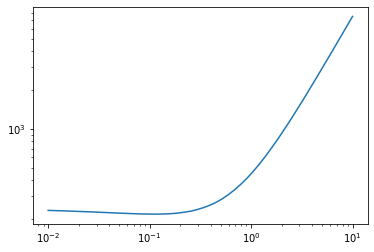

In [63]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(3.97358e-45)),
 (1, 0.011513953993264475, DM(8.62522e-45)),
 (2, 0.013257113655901088, DM(1.79108e-44)),
 (3, 0.015264179671752334, DM(4.70244e-44)),
 (4, 0.017575106248547922, DM(1.18162e-43)),
 (5, 0.020235896477251575, DM(0.000463997)),
 (6, 0.023299518105153717, DM(9.6558e-06)),
 (7, 0.02682695795279726, DM(0.0404234)),
 (8, 0.030888435964774818, DM(7.09851e-42)),
 (9, 0.03556480306223128, DM(0.00131435)),
 (10, 0.040949150623804255, DM(0.169958)),
 (11, 0.04714866363457394, DM(0.372466)),
 (12, 0.054286754393238594, DM(0.233135)),
 (13, 0.06250551925273973, DM(0.739192)),
 (14, 0.07196856730011521, DM(1)),
 (15, 0.08286427728546843, DM(0.00124118)),
 (16, 0.09540954763499938, DM(0.809217)),
 (17, 0.10985411419875583, DM(0.481874)),
 (18, 0.12648552168552957, DM(0.0269682)),
 (19, 0.14563484775012436, DM(0)),
 (20, 0.16768329368110083, DM(3.80952e-10)),
 (21, 0.19306977288832497, DM(0.000239872)),
 (22, 0.22229964825261944, DM(2.66344e-42)),
 (23, 0.2559547922699536, 

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

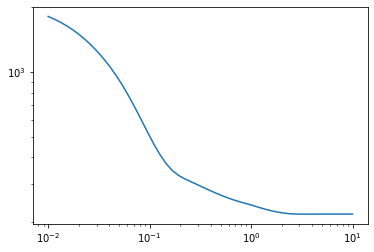

In [64]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.0610028)),
 (2, 0.013257113655901088, DM(0.00331744)),
 (3, 0.015264179671752334, DM(0.000163476)),
 (4, 0.017575106248547922, DM(7.45943e-06)),
 (5, 0.020235896477251575, DM(3.2404e-07)),
 (6, 0.023299518105153717, DM(1.38751e-08)),
 (7, 0.02682695795279726, DM(6.11225e-10)),
 (8, 0.030888435964774818, DM(2.91592e-11)),
 (9, 0.03556480306223128, DM(1.59746e-12)),
 (10, 0.040949150623804255, DM(1.06841e-13)),
 (11, 0.04714866363457394, DM(9.20312e-15)),
 (12, 0.054286754393238594, DM(1.05543e-15)),
 (13, 0.06250551925273973, DM(1.62158e-16)),
 (14, 0.07196856730011521, DM(3.28284e-17)),
 (15, 0.08286427728546843, DM(8.49998e-18)),
 (16, 0.09540954763499938, DM(2.72262e-18)),
 (17, 0.10985411419875583, DM(1.04433e-18)),
 (18, 0.12648552168552957, DM(4.65531e-19)),
 (19, 0.14563484775012436, DM(2.35068e-19)),
 (20, 0.16768329368110083, DM(1.31611e-19)),
 (21, 0.19306977288832497, DM(8.02825e-20)),
 (22, 0.22229964825261944, DM(5.25973e-2

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[5759.452085477237, 5270.2449794987015, 5752.16684951662, 5758.035270250542]

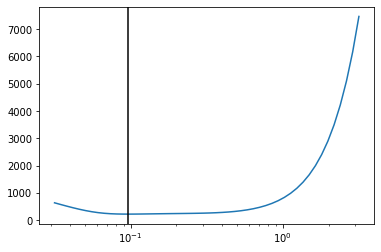

In [67]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(pvals, f2)
# plt.yscale('log')
plt.axvline(float(pref[2]), color='k')

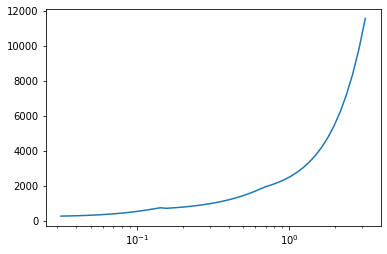

In [68]:
f3 = [(x['f']) for x in profiles[3]]
plt.semilogx(pvals, f3)

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [49]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

78.18181818181819


In [50]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(4517.89), DM(510.221), DM(125.097), DM(128.346), DM(808.267)]

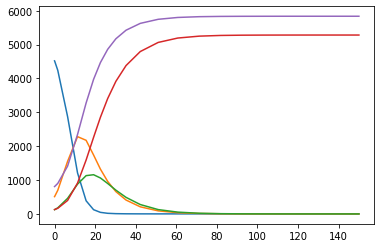

In [51]:
plt.plot(sol.t, sol.y[:,:].T)

In [52]:
plt.plot(solb.t, solb.y.T)

NameError: name 'solb' is not defined

In [ ]:
model.observation_times[-1]

In [ ]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [ ]:
rfin = sol.sol(tfine)[-1,-1]
rfin

In [ ]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [ ]:
tfine[ridx]

In [ ]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

In [ ]:
model.observation_times[-1]-model.observation_times[tidx]

In [ ]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

In [ ]:
rfin*historical_mortality

In [ ]:
rfin*current_mortality

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, np.gradient(getx(sols[i]['x'])[4].toarray().flatten(), model.observation_times),
            color=scalarMap.to_rgba(np.log10(p)), alpha=0.3)
plt.plot(times, np.gradient(cumdata, times), 'ro')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)